### Neural Diffusion Process on Melbourne Pedestrian Dataset

In [1]:
import math
import einops
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
import torch.nn.functional as F
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Util codes

In [2]:
from scipy.spatial import distance

def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K

def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch

def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np

def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
    
print ("Ready")

Ready


`NDP` Equations 

Given state $s_t = (x_t, y_t)$, 

#### Forward diffusion process:
$$q(s_t|s_{t-1}) = \mathcal{N}\left(s_t; ~\sqrt{1-\beta_t}s_{t-1}, \beta_t I \right)$$

Due to fixed Markov chain $q(s_{0:T}) = q(s_0) \prod_{t=1}^T q(s_t | s_{t-1})$

Following satistified:
$$q(s_t|s_0) = \mathcal{N}\left( s_t; \sqrt{\bar{\alpha}_t} s_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

#### Reverse diffusion process posterior:
$$ 
q(s_{t-1}|s_t,s_0) 
= \mathcal{N}
\left(
s_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Approximating the mean with denosing model $\epsilon_\theta(s_t, t)$ it is possible to rewrite as backward kernel $p_\theta(s_{t-1} | s_t)$ as follows

$$
p_\theta(s_{t-1}|s_t) 
= \mathcal{N}
\left(
s_{t-1}; \frac{1}{\sqrt{\alpha_t}} (s_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(s_t, t)),
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)

$$

### DDPM/NDP Regression using linear beta scheduling hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=500$ 

Ready.


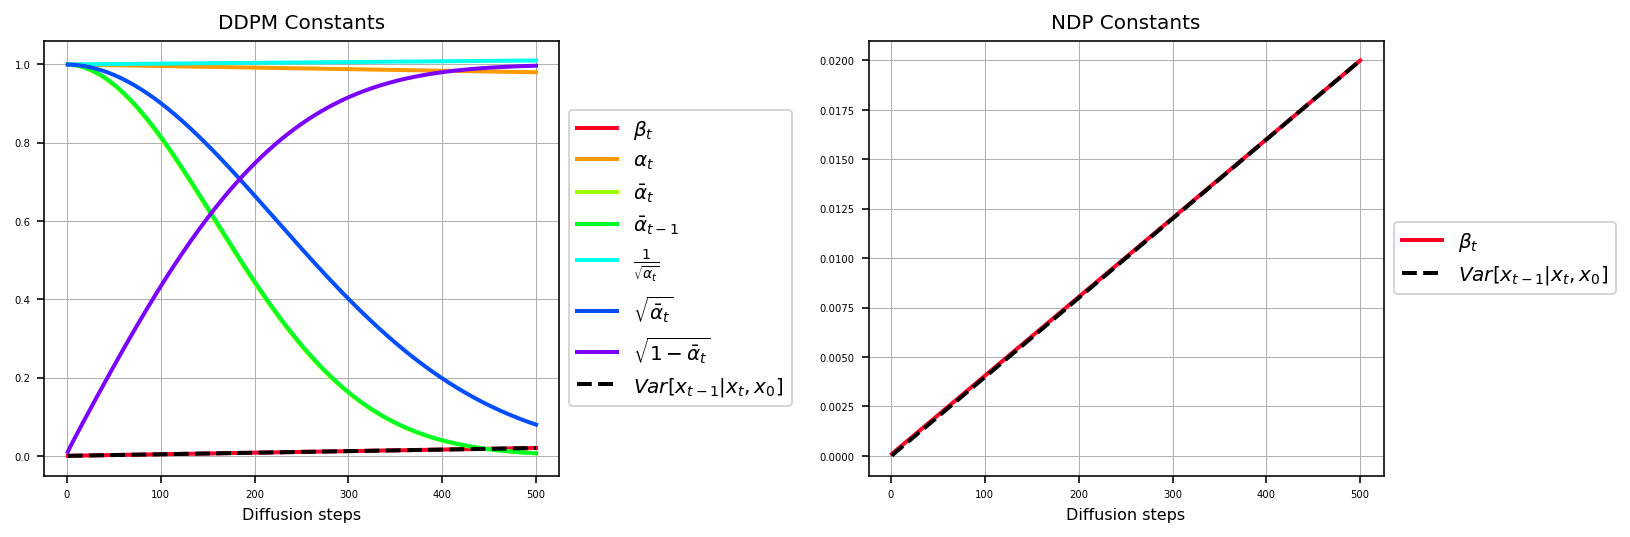

In [7]:
# Precompute some constants for NDP
# Linear Beta scheduling
dc = {}
dc['T'] = 500
dc['betas'] = torch.linspace(start=1e-4,end=2e-2,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### DDPM/NDP Regression using cosine beta scheduling hyper-parameters:
$T=500$, $t_i = i / T$, $t_{i+1} = (i+1) / T$, $\beta = \min(1 - \alpha(t_{i+1}) / \alpha(t_{i}), 0.999)$ and
$\alpha(t) = cos\left( \frac{t + 0.008}{1.008} \cdot \frac{\pi}{2} \right)^2$

Ready.


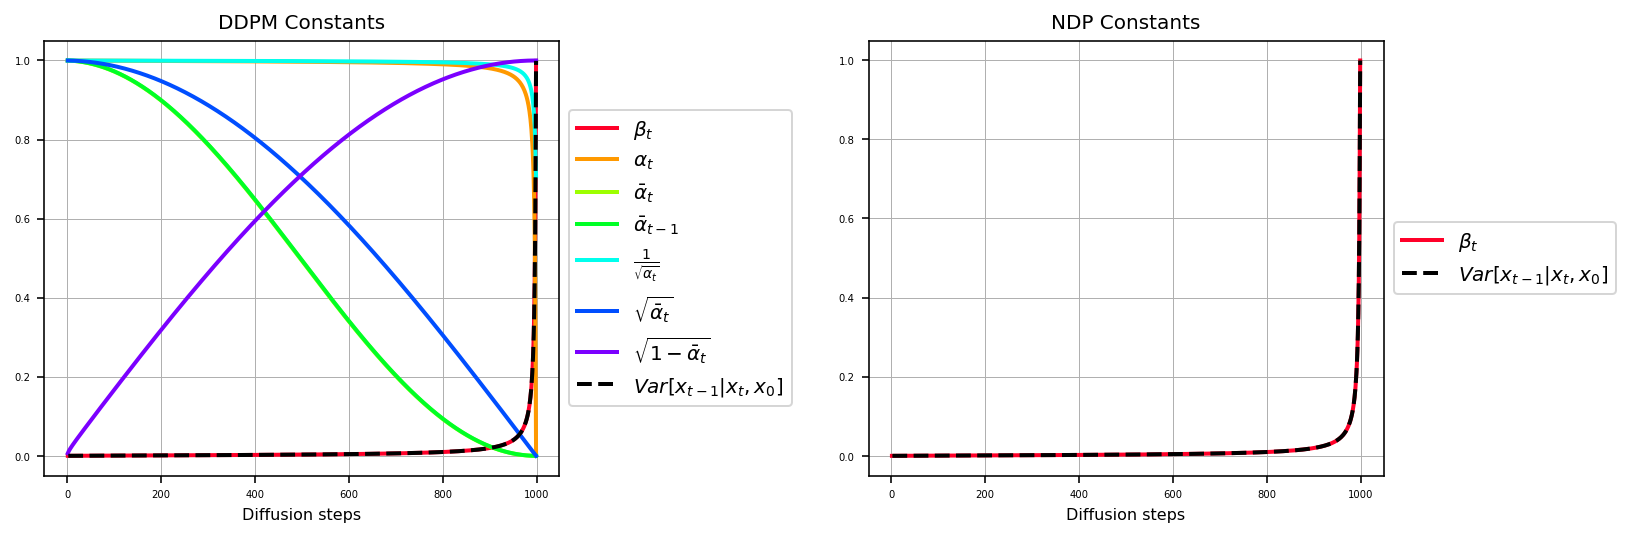

In [23]:
# Precompute some constants for NDP
# Cosine Beta scheduling - legacy
def alpha_bar(t):
    return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2 / math.cos((0 + 0.008) / 1.008 * math.pi / 2) ** 2

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.clamp(torch.tensor(betas), 0., 0.999)

dc = {}
dc['T'] = 999
dc['betas'] = betas_for_alpha_bar(dc['T'], alpha_bar=alpha_bar, max_beta=0.999)
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/(1 - 1e-5+dc['betas']) ) # [T]
# dc['sqrt_recip_alphas'] = torch.sqrt(1.0/( 1e-5+dc['alphas']) ) # [T]
# dc['sqrt_recip_alphas'] = torch.clamp(torch.sqrt(1.0/dc['alphas']), max=1.01)
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
# dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar'])/(1.0-dc['alphas_bar_prev']) # [T]

print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

Ready.


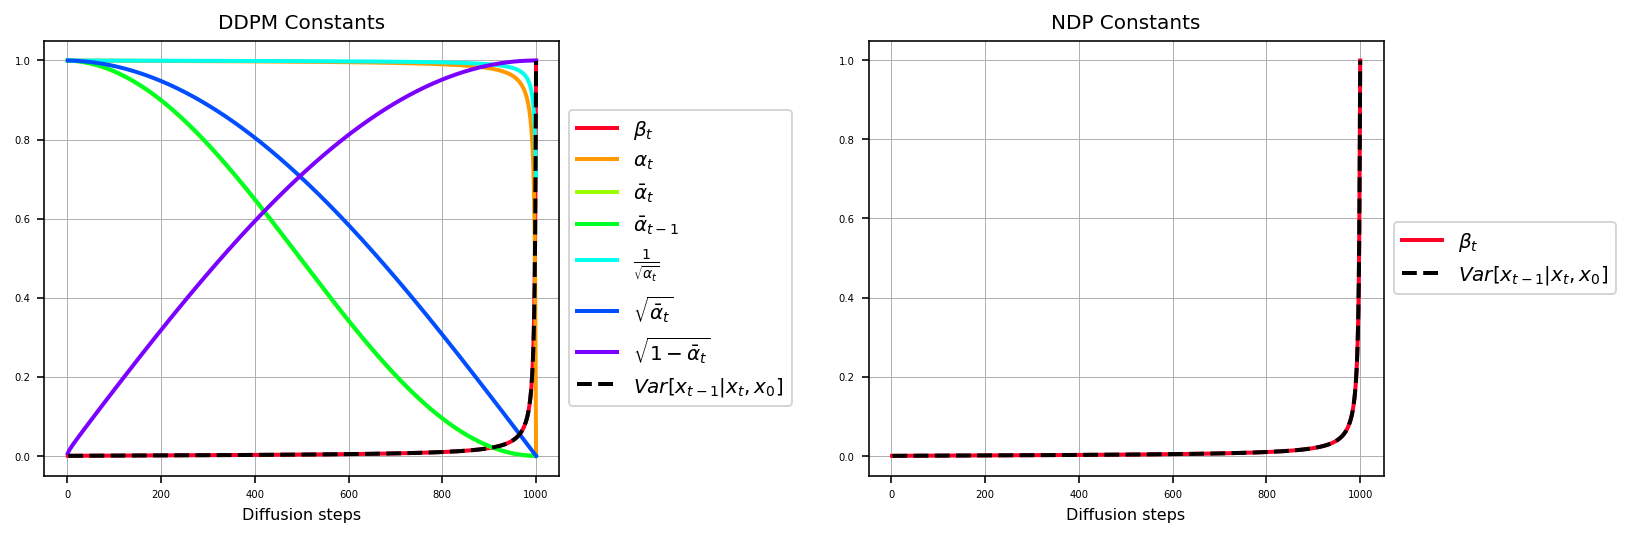

In [3]:
# Precompute some constants for NDP
# Cosine Beta scheduling
def alpha_bar(t):
    return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2 / (math.cos((0.008) / 1.008 * math.pi / 2) ** 2)

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.clamp(torch.tensor(betas),0,0.999)

dc = {}
dc['T'] = 1000
dc['betas'] = betas_for_alpha_bar(dc['T'], alpha_bar=alpha_bar, max_beta=0.999)
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/(1.0 - 1e-5 + dc['betas'])) # [T]
# dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
# dc['sqrt_recip_alphas'] = torch.clamp(torch.sqrt(1.0/dc['alphas']), max=1.1)
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
# dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar'])/(1.0-dc['alphas_bar_prev']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$, $\phi \sim p_\phi$, $\mathbf{y}_0 \sim \mathcal{N}(\mathbf{0}, k_\phi(\mathbf{x}_0, \mathbf{x}_0) + \sigma^2 \mathbf{I})$\
2: $\bar{\alpha_t} = \prod_{s=1}^t(1-\beta_s)$, $\gamma_t = \sqrt{1 - \bar{\alpha_t}}$, and $t \sim \text{Uniform}(\{ 1, \ldots, T \})$,\

3: $ \boldsymbol{\color{red} \epsilon_x, \color{blue} \epsilon_y} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \

$\bold{Case 1}$: If only diffuse on the observations, \
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$ \
5: Take gradient descent step on the observation
$$ 
    \nabla \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2
$$
$\bold{Case 2}$: If diffuse both on sample and observations,\
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$, and  $\mathbf{x}_t = \sqrt{\bar{\alpha_t}}\mathbf{x}_0 + \gamma_t \boldsymbol{\color{red} \epsilon_x} $ \
5: Take gradient descent step on both input and observations

$$ 
    \nabla \left[ \| \boldsymbol{\color{red} \epsilon_x} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon_x}, t
        ) \|^2
    + \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2 
    \right]
$$

## TODO: Fix prior sampling part for NDP
### `Algorithm 2` Sampling 
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Forward diffusion sampler

In [4]:
def forward_diffusion_sample(x_0, steps, dc):
    """
        x_0: torch.Tensor [B x D x L]
        K_chols: torch.Tensor [D x L x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x D x L]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x D x L]
    noise = torch.randn_like(input=x_0) # [B x D x L]
    
    x_t = x_t_mean + x_t_std * noise
    return x_t, noise

### Define Melborune Pedestrian Dataset

In [5]:
from sktime.datasets import load_from_arff_to_dataframe

class DatasetStandardizer:
    def __init__(self, axis=[0,1,2]):
        self.axis = axis
        pass

    def fit(self, dataset):
        self.mean = dataset[self.axis].mean()
        self.std = dataset[self.axis].std()

    def transform(self, dataset):
        y = dataset
        y = y - self.mean
        y = y / self.std
        return y

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

class MelbourneDataset(torch.nn.Module):
    def __init__(self, phase='train', train_test_ratio=0.8, seed=42):
        super(MelbourneDataset, self).__init__()

        self.phase = phase
        self.scaler = DatasetStandardizer()
        self.seed = seed
        self.x_train, self.y_train, self.x_valid, self.y_valid, self.x_test, self.y_test \
            = self._get_melbourne_dataset(train_test_ratio)

    def __len__(self):
        if self.phase == 'train':
            return self.x_train.shape[0]
        elif self.phase == 'valid':
            return self.x_valid.shape[0]
        else:
            return self.x_test.shape[0]
    
    def __getitem__(self, idx):

        if self.phase == 'train':
            x, y = self.x_train, self.y_train
        elif self.phase == 'valid':
            x, y = self.x_valid, self.y_valid
        else:
            x, y = self.x_test, self.y_test
            
        return x[idx], y[idx]
    
    def _get_melbourne_dataset(self, train_test_ratio):
        np.random.seed(self.seed)
        # train_file_path = '/home/seungwoos/sp-sgm/data/MelbounePedetrian/MelbournePedestrian_TRAIN.arff'
        test_file_path = '/home/seungwoos/sp-sgm/data/MelbounePedetrian/MelbournePedestrian_TEST.arff'

        data = load_from_arff_to_dataframe(test_file_path)
        samples = []

        for i in range(data[0].shape[0]):
            samples.append(torch.tensor(data[0]['dim_0'][i]))

        y_full = torch.stack(samples, axis=0)
        ind = torch.isnan(y_full).sum(axis=1) == 0
        y_full = y_full[ind].float()
        x_full = torch.arange(y_full.shape[1], dtype=torch.float).unsqueeze(-1)

        num_train = int(y_full.shape[0] * train_test_ratio)

        train_indices = np.random.choice(y_full.shape[0], size=num_train, replace=False)
        eval_indices = np.setdiff1d(np.arange(y_full.shape[0]), train_indices)

        x_train = x_full.repeat(num_train, 1, 1)
        y_train = y_full[train_indices].unsqueeze(-1)

        x_test = x_full.repeat(y_full.shape[0] - num_train, 1, 1)
        y_test = y_full[eval_indices].unsqueeze(-1)

        y_train = self.scaler.fit_transform(y_train)
        y_test = self.scaler.transform(y_test)
        
#         y_train = torch.log(y_train)
#         y_test = torch.log(y_test)
        
        num_test = int(y_test.shape[0] * 0.5)

        x_valid = x_test[:num_test]
        y_valid = y_test[:num_test]

        x_test = x_test[num_test:]  
        y_test = y_test[num_test:]

        return x_train, y_train, x_valid, y_valid, x_test, y_test

In [6]:
train_dataset = MelbourneDataset(phase='train')
valid_dataset = MelbourneDataset(phase='valid')
test_dataset = MelbourneDataset(phase='test')

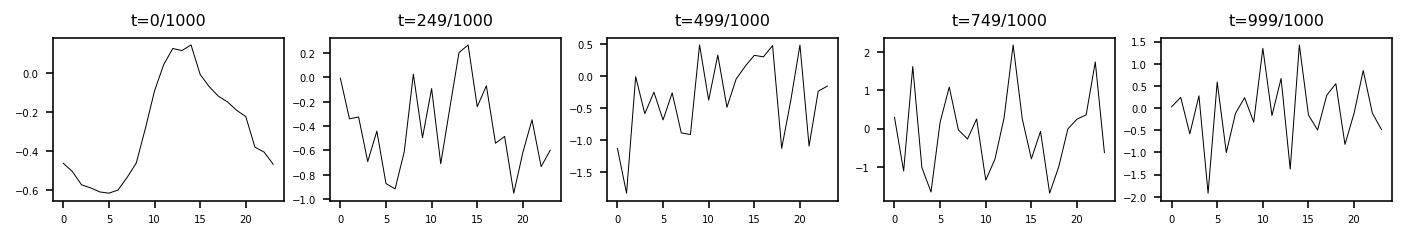

In [7]:
# Check forward diffusion

check_data = MelbourneDataset(phase='train')
x_0, y_0 = check_data[0]

steps = torch.linspace(start=0, end=dc['T']-1, steps=dc['T']//200).long()

plt.figure(figsize=(12,1.5))
for i, step in enumerate(steps):
    t = int(step.item())
    y_t_mean = dc['sqrt_alphas_bar'][t] * y_0 
    y_t_std = dc['sqrt_one_minus_alphas_bar'][t]
    noise = torch.randn_like(y_0)
    y_t = y_t_mean + y_t_std * noise 
    
    plt.subplot(1, len(steps), i+1)
    plt.plot(torch2np(x_0)[:,0], torch2np(y_t)[:,0], color='k', lw=1/2)
    plt.title('t=%d/%d'%(torch2np(step),dc['T']),fontsize=8)
plt.show()

### Network - Official code implemented in PyTorch with minor modifications from previous implementation

#### Notation
- N : the sequence length
- D : input dimension
- H : the hidden embedding dimension

In [8]:
class MultiHeadSelfAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads  = num_heads
        head_dim        = dim // num_heads
        self.scale      = head_dim ** -0.5

        # self.q          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.k          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.v          = nn.Linear(dim, dim, bias=qkv_bias)
        self.qkv        = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.attn_drop  = nn.Dropout(attn_drop)
        self.proj       = nn.Linear(dim, 2 * dim)
        self.proj_drop  = nn.Dropout(proj_drop)        

    def forward(self, s):
        
        B, N, D, H = s.shape
        qkv = self.qkv(s).reshape(B, N, D, 3, self.num_heads, H//self.num_heads)
        # print(f'qkv size = {qkv.size()}')
        qkv = qkv.permute(3, 0, 4, 1, 2, 5)
        # print(f'qkv size = {qkv.size()}')
        q, k, v = qkv.unbind(0)
        # print(f'q size = {q.size()}, k size = {k.size()}, v size = {v.size()}')

        
        attn_score = (q @ k.transpose(-2, -1)) * self.scale
        # print(f'attention score size = {attn_score.size()}')
        attn_score = attn_score.softmax(dim=-1)
        attn_score = self.attn_drop(attn_score)

        # attention on dim D
        attn = (attn_score @ v).transpose(2, 3).reshape(B, N, D, H)
        # print(attn.size())
        attn = self.proj(attn)
        attn = self.proj_drop(attn)
        return attn

class BiDimensionalAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., norm = 'layernorm', activation='relu', pre_norm = True):
        super().__init__()
        self.MHSA_D = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)
        self.MHSA_N = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)

        self.norm = self._get_norm_layer(norm, dim)
        self.activation = self._get_act_fn(activation)
        self.pre_norm = pre_norm
        
        self.t_embed = nn.Linear(dim, dim)

    def forward(self, s, t):
    
        t = self.t_embed(t)[:, None, None, :] # ensure the shape of t should be [batch_size, 1, 1, H]
        s_t = s + t # ensure the shape of t should be [batch_size, N, D, H]

        y_d = self.MHSA_D(s_t)
        y_n = self.MHSA_N(s_t.transpose(1, 2)).transpose(1, 2)

        a = y_d + y_n
        residual, skip = torch.tensor_split(a, 2, dim=-1)
        residual = self.activation(residual)
        skip = self.activation(skip)

        return (s + residual) / math.sqrt(2.0), skip


    def _get_norm_layer(self, norm, dim):
        if norm.lower() == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm.lower() == 'batchnorm':
            return nn.BatchNorm1d()
        else:
            return nn.Identity()

    def _get_act_fn(self, activation):
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'silu':
            return nn.SiLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        else:
            raise NotImplementedError 


class NDPModel(nn.Module):
    def __init__(self,
                 name        = 'neural_diffusion_process_fixed',
                 D           = 3,
                 L           = 100,
                 pos_emb_dim = 128,
                 hidden_dim  = 64,
                 n_layers    = 5,
                 num_heads   = 8,
                 qkv_bias    = False,
                 attn_drop   = 0.,
                 proj_drop   = 0.,
                 norm        = 'layernorm',
                 activation  = 'relu',
                 pre_norm    = True,
                 actv        = nn.ReLU(),
                ):
        super().__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.num_heads   = num_heads
        self.qkv_bias    = qkv_bias
        self.attn_drop   = attn_drop
        self.proj_drop   = proj_drop
        self.norm        = norm
        self.activation  = activation
        self.pre_norm    = pre_norm
        self.actv        = actv
        
        # Initialize layers
        self.init_layers()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()

        # Preprocess embedding layer
        # If y as a prior or a function value is given
        self.layers['Preprocess'] = nn.Sequential(
            nn.Linear(2, self.hidden_dim),
            nn.GELU(),
        )
    

        # Bi-dimensional attention blocks
        for i in range(self.n_layers):
            self.layers['Attn_block_%02d'%(i)] = BiDimensionalAttentionClass(
                dim=self.hidden_dim, num_heads=self.num_heads, qkv_bias=self.qkv_bias,
                attn_drop=self.attn_drop, proj_drop=self.proj_drop, norm=self.norm,
                activation=self.activation, pre_norm=self.pre_norm)
        
        # y noise generation
        self.layers['Out'] = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1, bias=False),)
        
    def forward(self, x, y, t):
        """
            Forward
        """
        s = self.preprocess(x, y) if y is not None else x.unsqueeze(-1)
        s = self.layers['Preprocess'](s)
        
        #TODO: check whether time embedding should be passed dense layer from pos_emb_dim -> hidden_dim
        t_embed = self.time_embed(t)

        # outs = torch.zeros_like(s)

        skip = None
        for i in range(self.n_layers):
            s, skip_connection = self.layers['Attn_block_%02d'%(i)](s, t_embed)
            skip = skip_connection if skip is None else skip_connection + skip

        skip_y = einops.reduce(skip, "b n d h -> b n h", "mean")

        eps_y = skip_y / math.sqrt(self.n_layers * 1.0)
        eps_y = self.layers['Out'](eps_y)
        return eps_y
    
    
    def preprocess(self, x, y):
        D = x.shape[-1] # num x_dim
        x = x.unsqueeze(-1) 
        y = torch.repeat_interleave(y.unsqueeze(-1), D, axis=2)
        conc = torch.cat([x, y], dim=-1)

        return conc

    def time_embed(self, steps, max_positions=10000):
        '''
        steps: random time step t with shape (batch_size,)
        max_positions: log(10000) = 4
        '''
        device = steps.device
        # half_dim = self.pos_emb_dim // 2
        half_dim = self.hidden_dim // 2

        # Before the official code releases
        # embeddings = torch.pow(10, torch.arange(half_dim, device=device, dtype=torch.float32) * 4 / (half_dim - 1))
        # After the official code releases
        # emb = jnp.log(max_positions) / (half_dim - 1)
        embeddings = np.log(max_positions) / (half_dim - 1)
        # emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
        embeddings = torch.exp(torch.arange(half_dim, device=device, dtype=torch.float32) * -embeddings)

        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # if self.pos_emb_dim % 2 == 1:
        if self.hidden_dim % 2 == 1:
            embeddings = F.pad(embeddings, [[0, 0], [0, 1]])
        
        # assert embeddings.shape == (steps.shape[0], self.pos_emb_dim)
        assert embeddings.shape == (steps.shape[0], self.hidden_dim)
        return embeddings 


print ("Ready.")    

Ready.


### Define loss function 

In [8]:
def get_regression_loss(model, x_0, y_0, t, dc, loss_type='l2'):
    """
        x_0: [B x L x D]
        y_0: [B x L x D]
    """
    # Forward diffusion

    # TODO: Diffuse only function values y - x can be diffuse in NDP
    # x_noisy,x_noise = forward_hilbert_diffusion_sample(
    #     x_0=x_0, K_chols=K_chols, steps=t, dc=dc, noise_rate=1.0, hilbert_sampling=hilbert_sampling) # [B x D x L]

    y_noisy, y_noise = forward_diffusion_sample(x_0=y_0, steps=t, dc=dc) # [B x 1 x L]
 
    # Predict noise
    noise_pred = model(x=x_0, y=y_noisy, t=t) # [B x L X 1]

    # Compute loss
    if loss_type == 'l1':
        loss = F.l1_loss(y_noise, noise_pred)
    elif loss_type == 'l2':
        loss = F.mse_loss(y_noise, noise_pred)
    elif loss_type == 'huber':
        loss = F.huber_loss(y_noise, noise_pred)
    else:
        raise NotImplementedError(f'Loss type should be [l1, l2, huber]] but got {loss_type}')
    return loss
print ("Ready")

Ready


### Train

In [8]:
def check_grad(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().cpu().numpy().mean())
            
    if max(ave_grads) > 1.0:
       print(max(ave_grads))

In [34]:
# Train

device = 'cuda:5' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE, D, L, MAX_ITER = 32,1,24,250
model = NDPModel(D=D, L=L, activation='gelu', norm='none').to(device)
print ("[%s] instantiated."%(model.name))

optimizer = torch.optim.Adam(
    model.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-06)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_losses = []
val_losses = []

check_epoch = MAX_ITER // 20

for it in range(MAX_ITER):
    train_loss = 0.0
    valid_loss = 0.0
    train_num = 0
    valid_num = 0

    model.train()
    for x_0, y_0 in train_loader:
        x_0 = x_0.to(device)
        y_0 = y_0.to(device)

        optimizer.zero_grad()

        t = torch.randint(0, dc['T'],(x_0.shape[0],),device=device).long() # [B]
        loss = get_regression_loss(model=model,x_0=x_0,y_0=y_0,t=t,dc=dc)
        loss.backward()
        check_grad(model.named_parameters())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item() * x_0.shape[0]
        train_num += x_0.shape[0]

    train_losses.append(train_loss / train_num)

    if (it % check_epoch) == 0:
        print ("[%d/%d] train loss:[%.3f]"%(it,MAX_ITER,train_losses[-1]))

    model.eval()
    with torch.no_grad():
        for x_0, y_0 in valid_loader:
            x_0 = x_0.to(device)
            y_0 = y_0.to(device)

            t = torch.randint(0, dc['T'],(x_0.shape[0],),device=device).long()
            loss = get_regression_loss(model=model,x_0=x_0,y_0=y_0,t=t,dc=dc)

            valid_loss += loss.item() * x_0.shape[0]
            valid_num += x_0.shape[0]

        val_losses.append(valid_loss / valid_num)

    if (it % check_epoch) == 0:
         print ("[%d/%d] validation loss:[%.3f]"%(it,MAX_ITER,val_losses[-1]))
 
torch.save(model.state_dict(), '/home/seungwoos/yet-another-diffusion-models/checkpoints/ndp_melbourne_cosine_T_1000_fix.pth')
print ("Done.")

[neural_diffusion_process_fixed] instantiated.
[0/250] train loss:[0.999]
[0/250] validation loss:[0.976]
[12/250] train loss:[0.306]
[12/250] validation loss:[0.233]
[24/250] train loss:[0.198]
[24/250] validation loss:[0.180]
[36/250] train loss:[0.192]
[36/250] validation loss:[0.191]
[48/250] train loss:[0.179]
[48/250] validation loss:[0.195]
[60/250] train loss:[0.168]
[60/250] validation loss:[0.145]
[72/250] train loss:[0.166]
[72/250] validation loss:[0.129]
[84/250] train loss:[0.161]
[84/250] validation loss:[0.176]
[96/250] train loss:[0.154]
[96/250] validation loss:[0.184]
[108/250] train loss:[0.165]
[108/250] validation loss:[0.160]
[120/250] train loss:[0.154]
[120/250] validation loss:[0.148]
[132/250] train loss:[0.152]
[132/250] validation loss:[0.147]
[144/250] train loss:[0.157]
[144/250] validation loss:[0.168]
[156/250] train loss:[0.145]
[156/250] validation loss:[0.150]
[168/250] train loss:[0.152]
[168/250] validation loss:[0.152]
[180/250] train loss:[0.158]

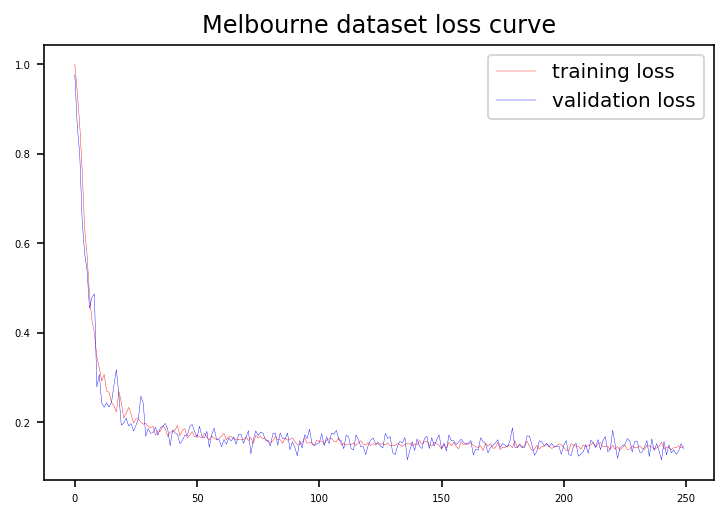

In [35]:
num_iter = range(MAX_ITER)
plt.plot(num_iter, train_losses, '-r', linewidth='0.2', label='training loss')
plt.plot(num_iter, val_losses, '-b', linewidth='0.2', label='validation loss')
plt.title('Melbourne dataset loss curve')
plt.legend(loc='upper right')
plt.show()

### Generation

In [9]:
# model.eval()
device = 'cpu'

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

model = NDPModel(D=1, L=24, activation='gelu', norm='none')
model.load_state_dict(torch.load('/home/seungwoos/yet-another-diffusion-models/checkpoints/ndp_melbourne_cosine_T_1000_fix.pth'))

y_t_s = []
y_0_s = []

for i, data in enumerate(test_loader):
    x_0, y_0 = data
    
    x_t = x_0.clone()

    noise = torch.randn_like(y_0) # [B x L x D]
    y_T = noise.clone()
    y_t = noise.clone()

    model.to(device)
    model.eval()
    print(x_t.shape, y_t.shape)
    # Generate
    y_ts = ['']*dc['T']
    for t in range(0,dc['T'])[::-1]:
        t_torch = torch.full((1,), t, device=device,dtype=torch.long)

        eps_t = model(x=x_t,y=y_t, t=t_torch) # [B x L X 1]

        # Diffusion constants
        betas_t = gather_and_reshape(
            values=dc['betas'],steps=t_torch,x_shape=x_t.shape) # [B x 1 x 1]
        sqrt_one_minus_alphas_bar_t = gather_and_reshape(
            values=dc['sqrt_one_minus_alphas_bar'],steps=t_torch,x_shape=x_t.shape)
        sqrt_recip_alphas_t = gather_and_reshape(
            values=dc['sqrt_recip_alphas'],steps=t_torch,x_shape=x_t.shape)

        # Compute posterior mean
        model_mean_t = sqrt_recip_alphas_t * (
            y_t - betas_t*eps_t/sqrt_one_minus_alphas_bar_t
        ) # [B x D x L]
        noise_t = torch.randn_like(y_t)

        # Compute posterior variance
        posterior_variance_t = gather_and_reshape(
            values=dc['posterior_variance'],steps=t_torch,x_shape=x_t.shape)
        # Sample
        # if t == 0: # last sampling, use mean
        #     y_t = model_mean_t
        # else:
        y_t = model_mean_t + torch.sqrt(posterior_variance_t) * noise_t
        # Append
        y_ts[t] = y_t # [B x D x L]
    
    y_t_s.append(y_t)
    y_0_s.append(y_0)
mean, std = test_dataset.scaler.mean, test_dataset.scaler.std 

# y_0 = y_0 * std + mean
# y_t = y_t * std + mean

# Plot original and generated data
for d_idx in range(D):
    # for b_idx in range(B):
    plt.figure(figsize=(20,4))        
    plt.subplot(1,3,1)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/2); 
    plt.grid('on')
    plt.title('Original quadratic data', fontsize=8); 
    plt.xlim(-1, 24)

    plt.subplot(1,3,2)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k',lw=1/2); 
    plt.grid('on')
    plt.title('Generated quadratic data', fontsize=8); 
    plt.xlim(-1, 24)

    plt.subplot(1,3,3)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/4); 
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k'); plt.grid('on')
    plt.title('Original and generated quadratic data',fontsize=8); 
    plt.xlim(-1, 24)
plt.show()


torch.Size([20, 24, 1]) torch.Size([20, 24, 1])
torch.Size([20, 24, 1]) torch.Size([20, 24, 1])
torch.Size([20, 24, 1]) torch.Size([20, 24, 1])
torch.Size([20, 24, 1]) torch.Size([20, 24, 1])
torch.Size([20, 24, 1]) torch.Size([20, 24, 1])


: 

: 

In [16]:
from scipy.stats import percentileofscore 
from sklearn.metrics import pairwise_distances

def K_ID(X, Y, gamma=1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the identity operator
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel, if -1 then median heuristic is used to pick gamma
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    if gamma == -1:
        gamma = np.median(dist_mat[dist_mat > 0])
   
    K = np.exp(-0.5*(1/gamma**2)*(dist_mat**2))
    return K

def MMD_K(K, M, N):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    M - number of samples from first distribution
    N - number of samples from first distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """
    
    Kxx = K[:N,:N]
    Kyy = K[N:,N:]
    Kxy = K[:N,N:]
    
    t1 = (1./(M*(M-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2./(M*N)) * np.sum(Kxy)
    t3 = (1./(N*(N-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

def two_sample_test(X, Y, hyp, n_perms, z_alpha = 0.05, make_K = K_ID, return_p = False):
    """
    Performs the two sample test and returns an accept or reject statement
    
    Parameters:
    X - (n_samples, n_obs) array of samples from the first distribution 
    Y - (n_samples, n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    return_p - option to return the p-value of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    
    Returns:
    rej - 1 if null rejected, 0 if null accepted
    p-value - p_value of test
    
    """
    
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]

    K = make_K(X, Y, hyp)

    # Empirical MMD^{2} calculated
    MMD_test = MMD_K(K, M, N)
    
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    for i in range(n_perms):
            idx = np.random.permutation(M+N)
            K = K[idx, idx[:, None]]
            shuffled_tests[i] = MMD_K(K,M,N)
    
    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0-z_alpha)
    rej = int(MMD_test > q)
    
    if return_p:
        p_value = 1-(percentileofscore(shuffled_tests,MMD_test)/100)
        return rej, p_value
    else:
        return rej

def power_test(X_samples,Y_samples,gamma,n_tests,n_perms,z_alpha = 0.05,make_K = K_ID,return_p = False):
    """
    Computes multiple two-sample tests and returns the rejection rate
    
    Parameters:
    X_samples - (n_samples*n_tests,n_obs) array of samples from the first distribution 
    Y_samples - (n_samples*n_tests,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_tests - number of tests to perform
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    return_p - option to return the p-value of the test
    
    Returns:
    power - the rate of rejection of the null
    """
    
    # Number of samples of each distribution is identified
    M = int(X_samples.shape[0]/n_tests)
    N = int(Y_samples.shape[0]/n_tests)
    rej = np.zeros(n_tests)

    # For each test, extract the data to use and then perform the two-sample test
    for t in range(n_tests):
        X_t = np.array(X_samples[t*M:(t+1)*M,:])
        Y_t = np.array(Y_samples[t*N:(t+1)*N,:])
        rej[t] = two_sample_test(X_t,Y_t,gamma,n_perms,z_alpha = z_alpha,make_K = make_K,return_p = return_p)

        reject = 'reject' if int(rej[t]) == 1 else 'not reject'
        print(reject)

        plt.figure(figsize=(12,4))
        X_t_label = 'Ground truth'
        Y_t_label = 'Generation'

        for i in range(M):
            plt.plot(X_t[i, :],'-',color='red', label=X_t_label)
            plt.plot(Y_t[i, :],'-',color='blue', label=Y_t_label)
            X_t_label = '_nolegend_'
            Y_t_label = '_nolegend_'
            
        plt.legend(loc='upper right')   
        plt.show()
        
    # Compute average rate of rejection
    power = np.mean(rej)
    return power

[ 0.07  0.01  0.08  0.05  0.03  0.01 -0.01  0.03  0.   -0.03  0.01 -0.01
  0.    0.02 -0.02  0.07  0.04  0.02  0.02  0.04  0.14 -0.02 -0.04  0.02
 -0.    0.04 -0.03 -0.02  0.09  0.03  0.09 -0.04 -0.06  0.04 -0.05 -0.03
 -0.05 -0.02 -0.05 -0.04  0.02  0.07 -0.04 -0.05  0.03 -0.06 -0.05  0.02
 -0.05 -0.05 -0.05  0.05  0.02  0.02 -0.05  0.2  -0.    0.06  0.01  0.01
 -0.    0.09 -0.07 -0.02  0.04 -0.04 -0.06 -0.01  0.01 -0.03 -0.05 -0.07
  0.02 -0.07 -0.03 -0.06  0.13  0.04 -0.03 -0.06  0.04  0.07  0.09 -0.
  0.02 -0.04 -0.05 -0.04 -0.02  0.04  0.05  0.   -0.    0.04 -0.05  0.
  0.02  0.06  0.01  0.  ]
reject


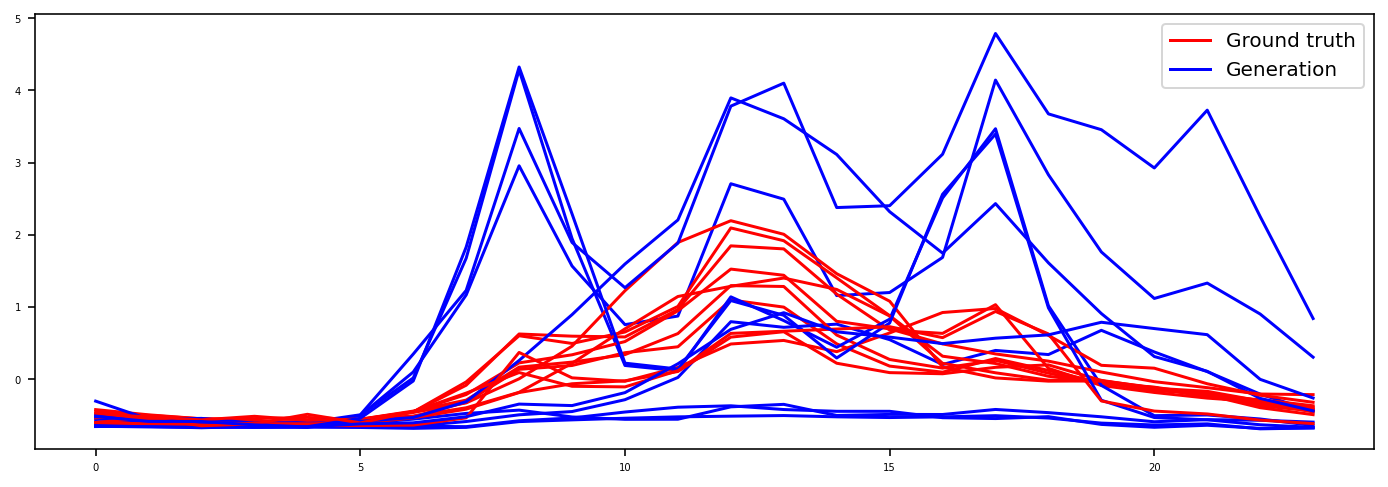

[ 0.14 -0.    0.04 -0.05  0.09 -0.05 -0.01 -0.02  0.    0.    0.07 -0.05
 -0.05 -0.05 -0.03  0.04 -0.01 -0.02  0.05  0.06  0.02 -0.05 -0.02  0.01
  0.07 -0.07 -0.05 -0.04 -0.   -0.06  0.01 -0.07  0.02  0.02 -0.07  0.04
  0.05  0.03 -0.02 -0.03 -0.01 -0.05  0.03  0.02  0.02 -0.03 -0.03 -0.07
 -0.05 -0.04 -0.05  0.07 -0.04 -0.    0.02  0.   -0.02 -0.07 -0.06 -0.01
  0.07  0.02 -0.01 -0.06  0.05 -0.04  0.06  0.03 -0.03  0.04  0.03 -0.06
 -0.   -0.06 -0.01  0.07 -0.05 -0.03 -0.04  0.02 -0.01 -0.04 -0.08  0.07
 -0.02  0.03 -0.01 -0.05  0.07  0.04  0.04 -0.04 -0.02  0.04 -0.04  0.06
 -0.04 -0.02 -0.01  0.1 ]
not reject


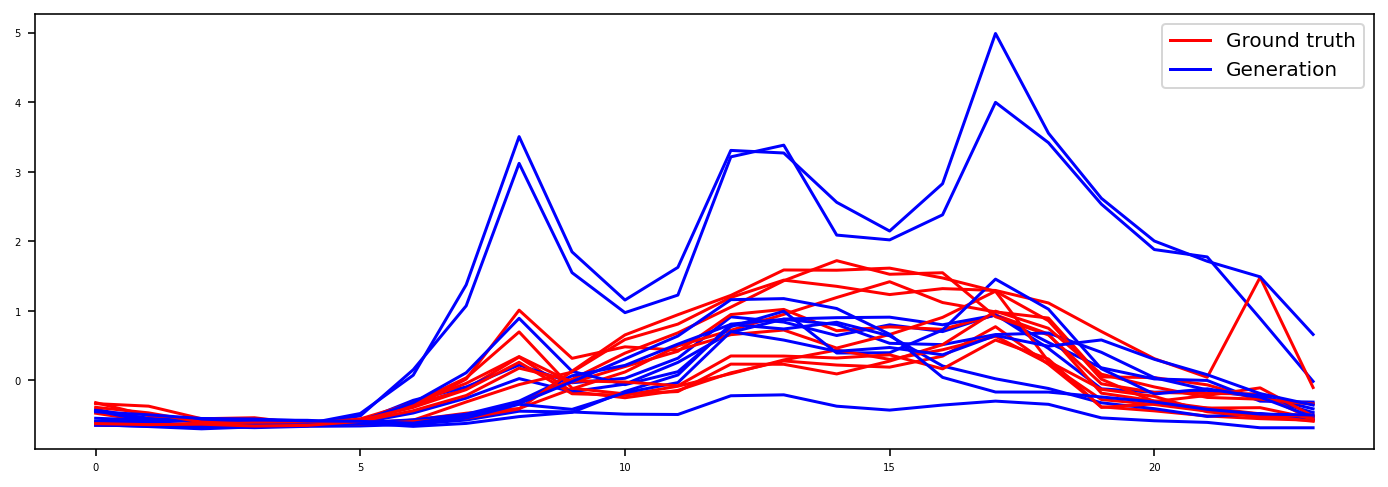

[ 6.10e-03 -3.95e-02 -4.78e-02  4.13e-03  3.11e-03  4.35e-02 -3.41e-02
 -2.79e-02 -3.36e-04 -2.95e-02 -1.67e-02 -1.70e-02 -2.09e-02 -4.32e-02
  4.38e-03 -1.16e-03 -2.47e-02  4.24e-02  1.20e-01  1.62e-02 -3.13e-02
 -4.81e-02  1.00e-02 -2.22e-02  1.47e-02 -6.53e-03  3.98e-02 -6.14e-02
  4.73e-02 -5.21e-02 -4.14e-02  1.01e-02 -4.54e-02 -4.85e-02  9.10e-02
  9.66e-02 -1.66e-02 -5.27e-03 -3.34e-03  2.05e-02 -4.13e-02 -1.26e-03
 -5.49e-02 -5.27e-02  3.75e-02  4.62e-02 -2.90e-02  2.76e-02  1.35e-01
 -1.25e-02  6.47e-03 -3.80e-02 -6.61e-02  1.44e-01  3.46e-02 -4.21e-02
 -4.05e-02 -3.09e-02 -6.12e-02 -3.64e-02  1.76e-01 -2.84e-02  4.22e-02
 -6.10e-02  4.98e-02  9.49e-02 -3.62e-02 -2.00e-02 -3.74e-02  1.31e-01
 -5.18e-02  9.03e-04 -4.60e-02 -6.02e-02  1.27e-02 -1.75e-04 -4.58e-02
  4.10e-02  3.00e-02  3.82e-02  2.22e-02  5.87e-02  1.48e-01  2.75e-02
  1.44e-02 -1.82e-02  4.59e-02 -3.30e-02  3.24e-02 -3.08e-02 -2.92e-02
  4.61e-02 -1.38e-02  4.04e-02 -4.34e-02  6.22e-02 -4.45e-02 -3.37e-02
 -1.16

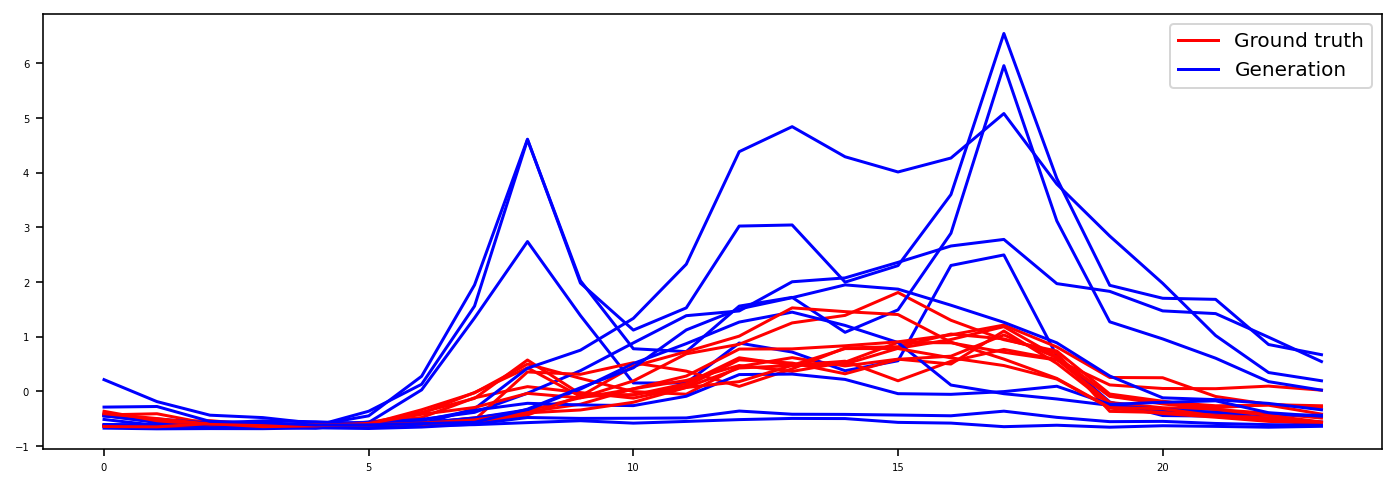

[ 1.64e-02 -4.76e-02  1.28e-02  4.47e-02 -3.50e-02  2.44e-02  9.45e-02
  5.72e-03 -4.71e-02  1.98e-02 -2.80e-02 -9.84e-03  4.16e-02  3.00e-02
 -4.16e-02 -8.24e-03 -3.25e-02 -2.16e-02 -4.67e-02  2.22e-02 -4.37e-03
 -7.22e-03 -3.14e-02 -5.27e-02 -2.38e-02  1.23e-02  1.58e-02 -1.86e-02
  1.05e-02  5.00e-02  6.65e-02 -2.09e-02  7.04e-02 -6.78e-02  2.71e-03
 -2.73e-02  1.24e-01 -5.51e-02  7.93e-02 -6.25e-02 -5.23e-02  6.26e-03
  1.90e-02  7.57e-02 -1.05e-02  5.84e-02  3.66e-03  3.24e-02 -2.51e-02
 -4.74e-02  9.69e-03 -5.30e-02  3.10e-02 -4.32e-02 -3.69e-02 -3.10e-02
  1.19e-02  2.92e-02 -3.24e-02  4.61e-02 -1.83e-02 -2.91e-02 -2.47e-02
 -1.22e-02 -5.43e-02  8.99e-02 -6.71e-03  1.02e-01  5.18e-02 -3.61e-02
 -1.59e-02 -5.00e-04  1.16e-02 -1.87e-02  8.87e-03 -1.84e-02  4.60e-02
 -1.75e-02 -6.19e-02 -3.52e-05  1.60e-02 -2.25e-02 -2.46e-03 -5.80e-02
 -5.74e-02 -3.51e-02  1.75e-01  4.18e-02  9.78e-03 -7.19e-03  9.58e-03
 -5.13e-03 -4.18e-02  7.32e-03 -4.91e-02 -1.75e-02 -4.53e-02 -4.37e-02
 -2.30

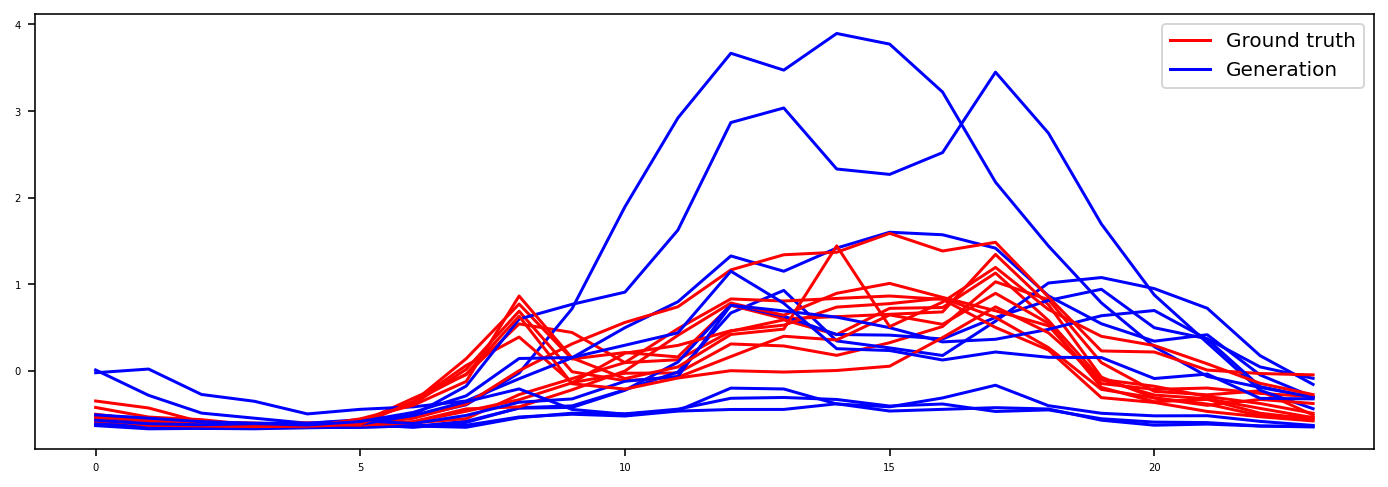

[-0.04 -0.05  0.07 -0.02 -0.03 -0.02 -0.01 -0.04 -0.05 -0.05 -0.    0.08
 -0.01 -0.02 -0.03 -0.02 -0.01 -0.02 -0.04 -0.03 -0.05 -0.06 -0.01 -0.01
  0.07  0.   -0.02 -0.06 -0.03 -0.    0.04  0.02  0.05  0.09  0.    0.
 -0.06 -0.03  0.02 -0.05 -0.03  0.11 -0.04  0.01  0.12 -0.04  0.06  0.03
 -0.06  0.    0.09  0.02  0.11 -0.04  0.03 -0.    0.02  0.06  0.02  0.04
  0.04  0.    0.01  0.06  0.09 -0.01 -0.04 -0.05 -0.06 -0.01 -0.01 -0.07
 -0.04  0.15  0.02  0.07  0.05 -0.02 -0.   -0.06 -0.03 -0.02 -0.03  0.02
 -0.05 -0.04 -0.01  0.01 -0.06 -0.03  0.01 -0.04 -0.01  0.02 -0.05 -0.03
  0.15  0.01  0.03 -0.05]
reject


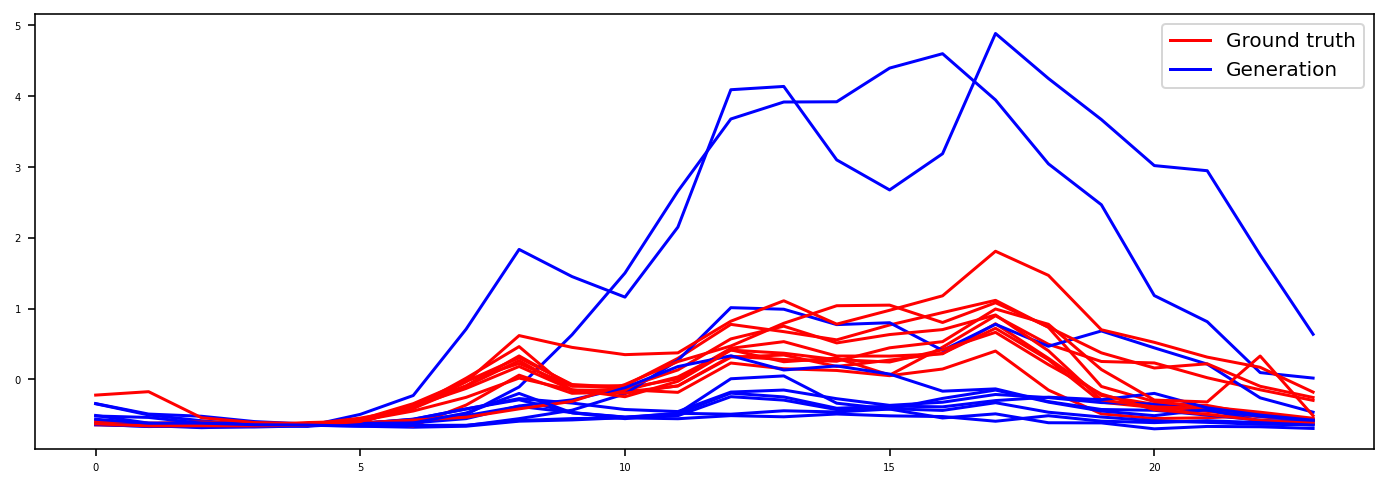

[-0.06  0.02 -0.03 -0.03 -0.01  0.03  0.02 -0.01  0.09 -0.05 -0.06  0.01
 -0.01  0.2  -0.03 -0.01 -0.06 -0.04  0.    0.   -0.03 -0.01  0.12  0.18
  0.02  0.1  -0.06  0.01 -0.03  0.21 -0.02 -0.03  0.01 -0.04 -0.01 -0.03
 -0.02 -0.05 -0.01 -0.05 -0.06 -0.02  0.06 -0.07  0.01 -0.04 -0.04 -0.06
  0.06 -0.05  0.02  0.04  0.15 -0.06 -0.02 -0.   -0.01 -0.02  0.02 -0.01
 -0.06 -0.06 -0.02 -0.04  0.01 -0.03 -0.02  0.08  0.01  0.2  -0.05  0.06
  0.01  0.1  -0.05 -0.06 -0.05  0.09 -0.03 -0.02 -0.01 -0.    0.04  0.1
  0.06 -0.02 -0.01  0.04 -0.01  0.09 -0.01 -0.05  0.02 -0.03 -0.04 -0.02
 -0.02 -0.01 -0.02 -0.02]
reject


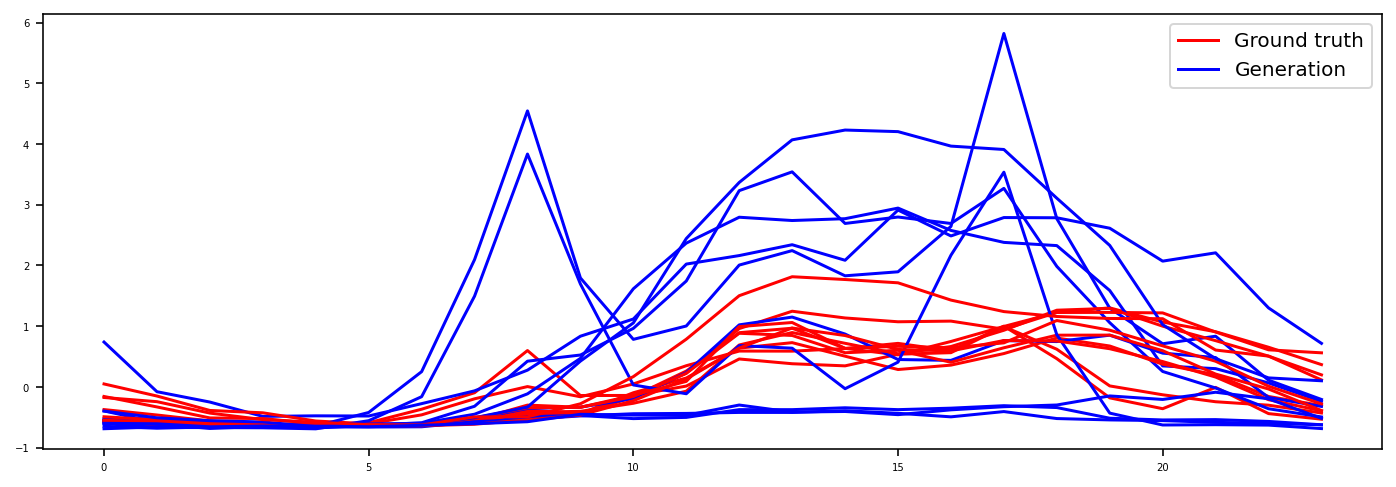

[-0.03  0.05 -0.01  0.03 -0.03 -0.06 -0.07 -0.05 -0.04  0.01  0.03  0.
 -0.04  0.06  0.03 -0.03  0.09  0.04 -0.01 -0.06 -0.02 -0.07  0.05  0.08
 -0.04 -0.03  0.08  0.01  0.02  0.02 -0.03 -0.07 -0.05  0.01 -0.02  0.08
 -0.02 -0.04  0.08 -0.02 -0.02 -0.05  0.02 -0.02 -0.04  0.02  0.05 -0.03
  0.02 -0.04 -0.06  0.04 -0.06  0.08  0.04 -0.03  0.13  0.02  0.06 -0.04
 -0.02  0.17 -0.07 -0.04  0.02  0.05 -0.07 -0.05 -0.04  0.12  0.01 -0.03
 -0.06  0.01 -0.02 -0.05  0.05 -0.07 -0.03  0.   -0.05  0.23  0.11 -0.05
 -0.05 -0.05  0.07  0.02 -0.07 -0.01  0.05 -0.04 -0.01 -0.04 -0.02  0.05
 -0.06 -0.02  0.02  0.08]
reject


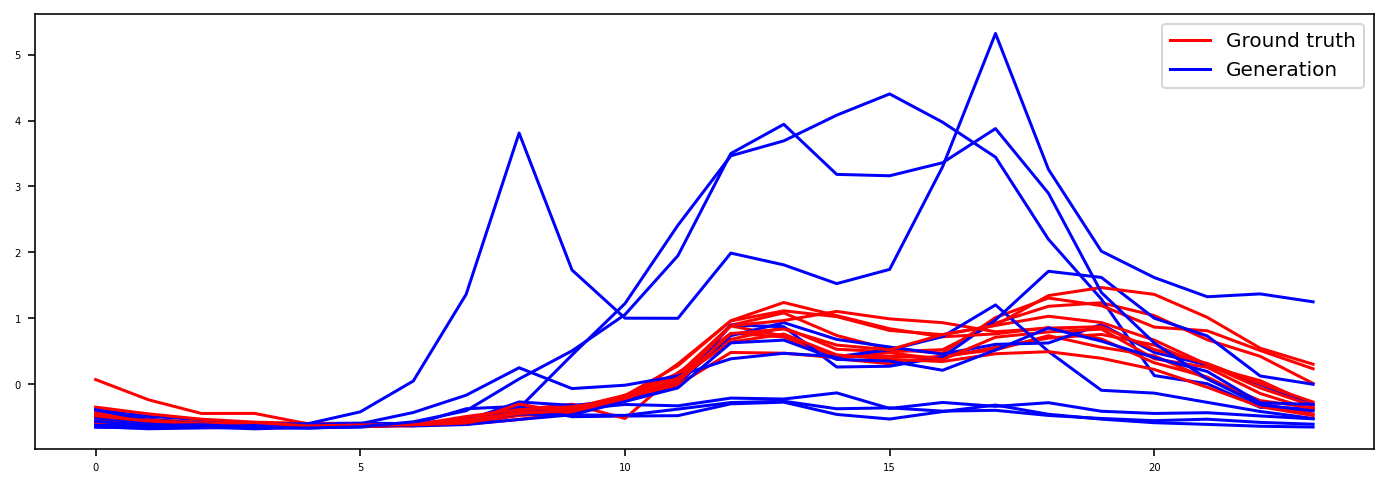

[-0.04  0.09 -0.05 -0.05 -0.04 -0.06 -0.06 -0.05 -0.06 -0.06  0.05 -0.03
 -0.03 -0.06 -0.02  0.04 -0.05  0.05  0.06  0.15  0.17 -0.05 -0.04  0.08
  0.03 -0.05 -0.05  0.05  0.01 -0.02 -0.06 -0.03 -0.02  0.05  0.07 -0.06
  0.03  0.11 -0.02  0.17 -0.01  0.14 -0.02 -0.03  0.01  0.17 -0.01 -0.06
  0.02  0.   -0.04 -0.04 -0.01 -0.01 -0.05 -0.03  0.03  0.01 -0.04 -0.01
 -0.06  0.04  0.08 -0.03 -0.01  0.02 -0.04  0.02  0.02 -0.05 -0.04  0.04
  0.14  0.07  0.06 -0.02  0.1  -0.05  0.16  0.01 -0.06  0.06 -0.   -0.06
  0.03  0.03  0.03 -0.04  0.11 -0.03 -0.01 -0.01 -0.05 -0.05  0.04 -0.02
  0.01 -0.05  0.04 -0.06]
reject


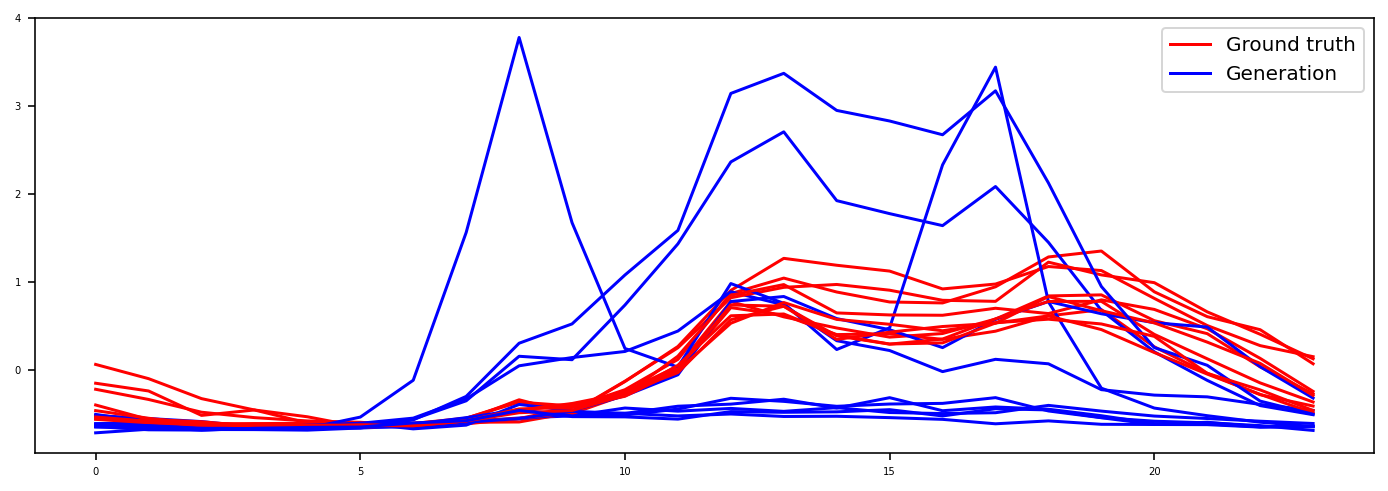

[-0.05  0.18  0.02  0.11 -0.02 -0.04 -0.06 -0.03 -0.03  0.1   0.04 -0.02
 -0.03 -0.04 -0.06 -0.04 -0.06 -0.07 -0.07 -0.02 -0.03 -0.06  0.05 -0.06
  0.06 -0.02 -0.06  0.04 -0.04 -0.05 -0.04  0.05  0.06 -0.07  0.01 -0.01
 -0.06 -0.02 -0.06 -0.03 -0.04  0.18 -0.06 -0.02  0.04  0.09 -0.05 -0.06
 -0.01  0.13 -0.05  0.   -0.05  0.03 -0.03 -0.04  0.07 -0.01 -0.02 -0.
 -0.03 -0.05 -0.    0.    0.06 -0.03 -0.02 -0.03 -0.    0.07 -0.06 -0.06
  0.14  0.07  0.01 -0.02  0.02  0.11 -0.07 -0.03 -0.01 -0.02  0.01 -0.04
  0.01  0.01 -0.06  0.01 -0.04  0.12  0.05  0.03  0.08  0.   -0.02  0.02
 -0.05 -0.01 -0.02 -0.07]
reject


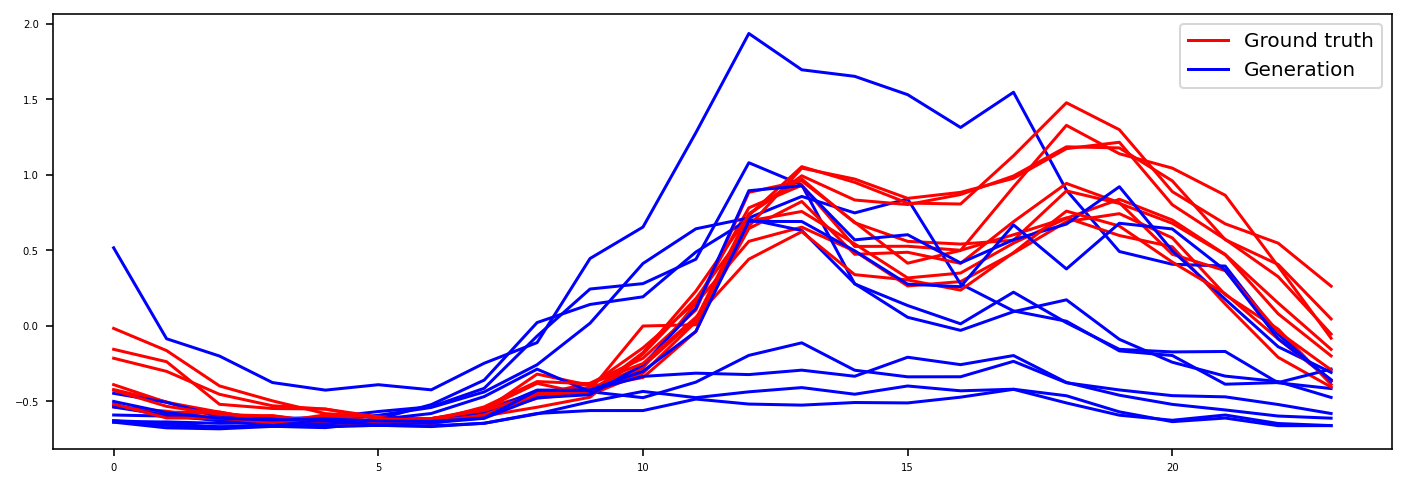

[-0.05 -0.05 -0.01  0.15 -0.01 -0.08 -0.04 -0.02 -0.07  0.15  0.   -0.03
  0.02 -0.01  0.05 -0.05 -0.03 -0.02 -0.04  0.05 -0.03  0.09 -0.03  0.16
 -0.03 -0.01 -0.03 -0.03  0.06 -0.03 -0.06  0.02 -0.02 -0.01 -0.03  0.03
 -0.03 -0.03  0.    0.06 -0.06 -0.07 -0.04 -0.07 -0.02  0.06 -0.04 -0.06
 -0.01  0.04 -0.04 -0.06 -0.04  0.1  -0.01 -0.02  0.05 -0.03 -0.07 -0.06
 -0.04 -0.03 -0.01 -0.01 -0.03  0.   -0.   -0.04 -0.04 -0.04  0.08 -0.04
 -0.03  0.02 -0.02 -0.03 -0.02 -0.02 -0.06 -0.04 -0.03  0.04 -0.01 -0.
 -0.07 -0.04 -0.07 -0.05  0.08  0.06  0.02 -0.01 -0.    0.06 -0.04 -0.01
 -0.06 -0.03 -0.01  0.14]
reject


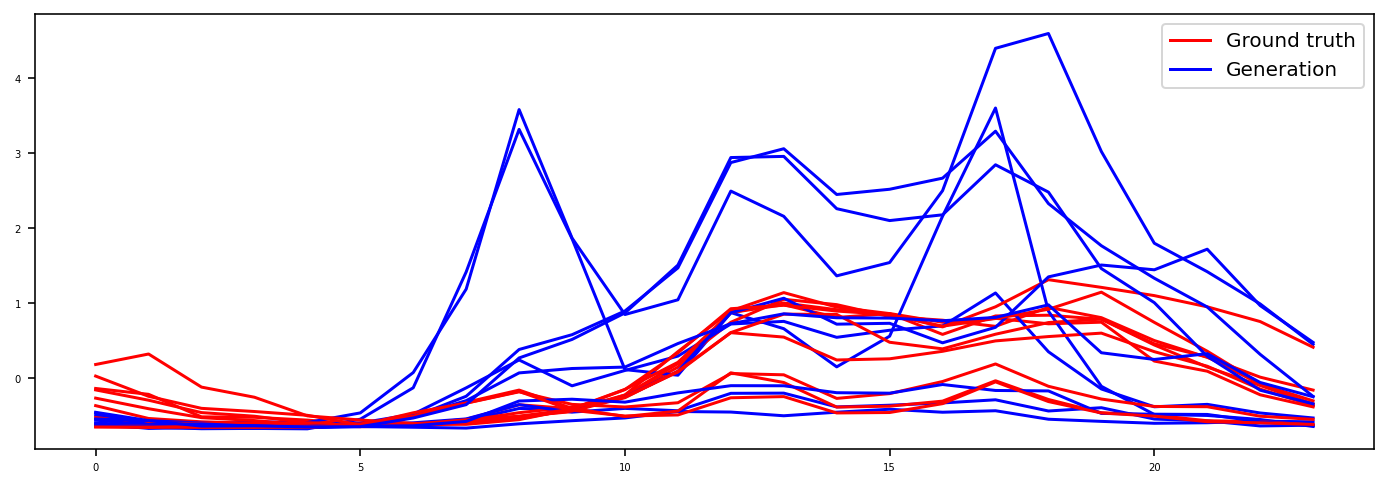

[-0.01 -0.05  0.09 -0.06 -0.04 -0.02  0.06 -0.05  0.03 -0.01 -0.05  0.14
  0.09 -0.02 -0.03 -0.05 -0.04 -0.04 -0.04 -0.04 -0.06 -0.02 -0.03 -0.06
 -0.06 -0.02  0.15 -0.02  0.07  0.04  0.33  0.03 -0.04 -0.02 -0.   -0.05
  0.09  0.12 -0.03  0.03 -0.01 -0.01  0.    0.03  0.   -0.03  0.15 -0.04
 -0.02 -0.04 -0.06 -0.05  0.08 -0.05 -0.07 -0.05  0.01 -0.02 -0.04 -0.01
 -0.04 -0.02 -0.01 -0.05  0.03 -0.06 -0.03 -0.06 -0.04 -0.04 -0.01 -0.04
  0.03 -0.02 -0.03 -0.05 -0.03 -0.03 -0.01 -0.05 -0.02 -0.06 -0.04  0.03
  0.38 -0.03  0.01 -0.04 -0.02  0.08 -0.05 -0.06 -0.02  0.05  0.04 -0.05
 -0.03 -0.01 -0.03  0.02]
reject


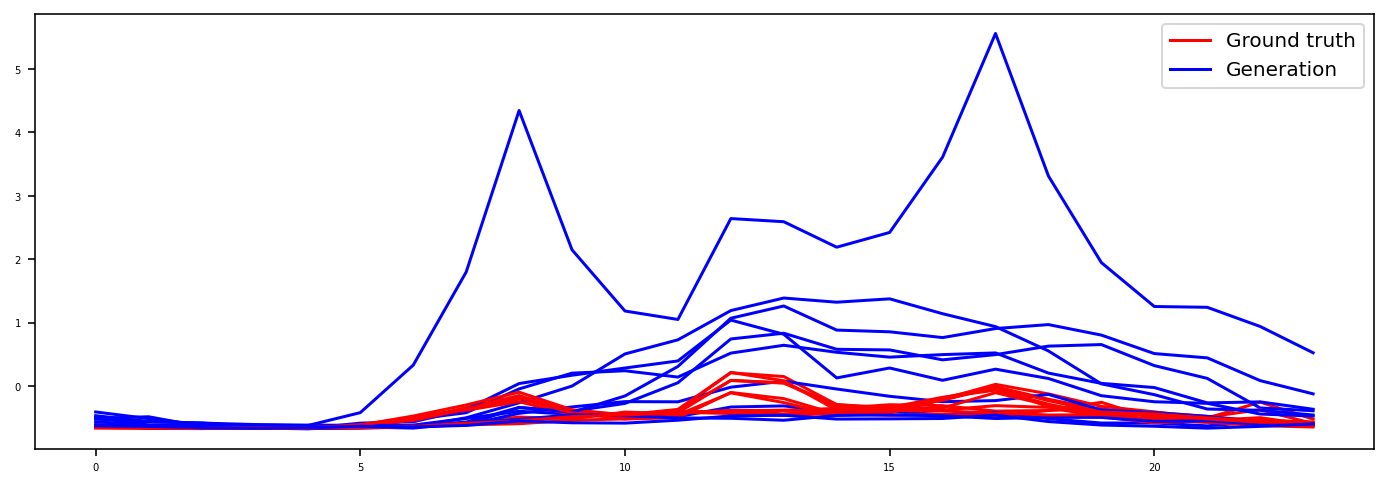

[-0.04 -0.04 -0.07 -0.03 -0.04 -0.   -0.02  0.03 -0.04 -0.06 -0.04 -0.05
  0.08 -0.07 -0.06 -0.03 -0.05 -0.06 -0.05 -0.02 -0.05 -0.06  0.27 -0.05
 -0.04 -0.03  0.04 -0.06  0.09 -0.06  0.12 -0.06 -0.05  0.06  0.01  0.03
 -0.02  0.02 -0.05  0.17 -0.07  0.02  0.   -0.02 -0.03  0.09 -0.05 -0.04
  0.03 -0.05  0.18 -0.04 -0.04 -0.07  0.05  0.   -0.05  0.    0.03 -0.02
  0.03  0.04 -0.02 -0.03 -0.03 -0.02 -0.03 -0.03  0.19 -0.07 -0.02 -0.02
 -0.    0.06 -0.01 -0.07  0.19 -0.04  0.02 -0.01  0.1  -0.   -0.05  0.1
 -0.06  0.01 -0.07  0.02 -0.06 -0.06 -0.03 -0.06 -0.03  0.24  0.14 -0.03
  0.12 -0.05 -0.06  0.04]
reject


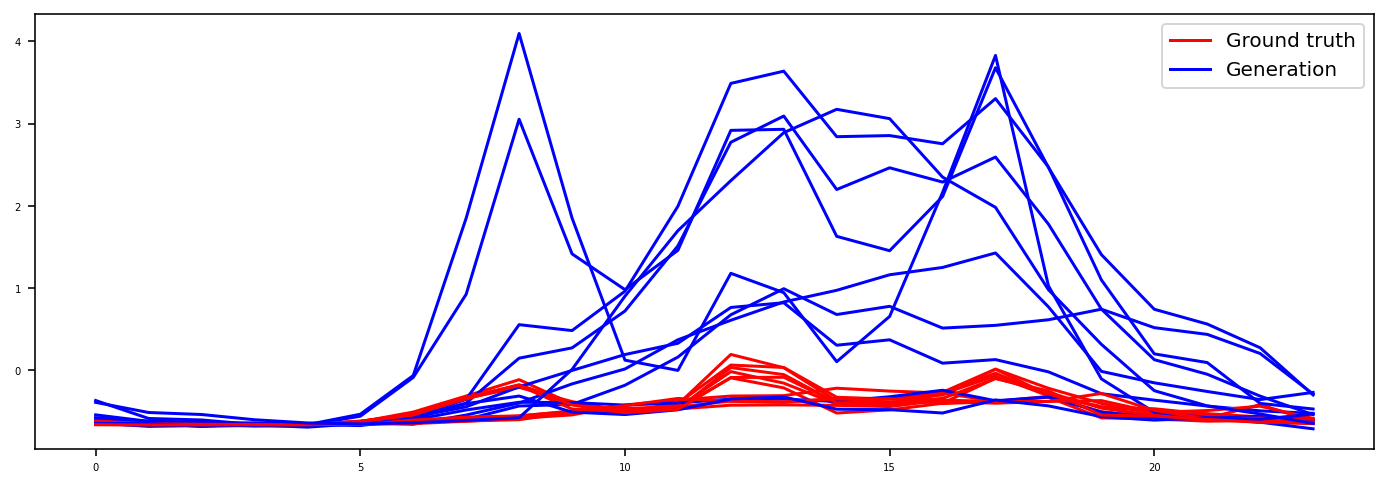

[-5.60e-02 -2.48e-02  1.34e-02 -3.07e-02  2.50e-02  2.15e-03 -3.63e-02
 -3.31e-02 -5.07e-02 -4.65e-02  2.02e-02  4.75e-03 -3.83e-02 -2.73e-02
  2.48e-02 -1.20e-02  4.78e-02 -1.49e-02 -1.28e-02  1.22e-01 -3.17e-02
 -1.26e-02  8.40e-02 -1.33e-02  6.22e-02  5.41e-02  1.16e-01  6.01e-02
 -2.47e-02  9.31e-03 -5.46e-02  1.85e-04  2.54e-02 -3.88e-02 -4.45e-02
  4.45e-02 -2.06e-02 -3.70e-02 -1.62e-02 -3.39e-02 -2.30e-02  2.75e-03
  6.15e-02 -4.66e-02  7.53e-02  3.42e-02 -3.19e-02  2.40e-02 -5.02e-02
 -3.11e-02  3.84e-02  4.57e-02 -3.01e-02 -3.23e-03  2.08e-02  1.76e-02
  1.31e-01  4.30e-02 -4.46e-02 -4.00e-02 -1.81e-02 -1.14e-02  7.61e-02
 -6.19e-02  1.18e-02 -3.29e-02 -2.88e-02 -3.95e-02 -1.16e-02 -4.09e-04
  3.90e-02 -3.52e-02 -5.46e-02  9.39e-02 -3.99e-02 -3.68e-02 -5.68e-02
  2.04e-01  1.43e-01 -2.62e-02  1.82e-01  1.09e-02  1.45e-01 -4.52e-02
  5.13e-03 -3.88e-02  3.89e-02 -5.16e-02  3.13e-02 -4.10e-02  1.14e-01
  1.16e-01 -3.94e-02 -1.54e-02  8.31e-02 -5.62e-02 -1.39e-02  4.93e-02
 -4.17

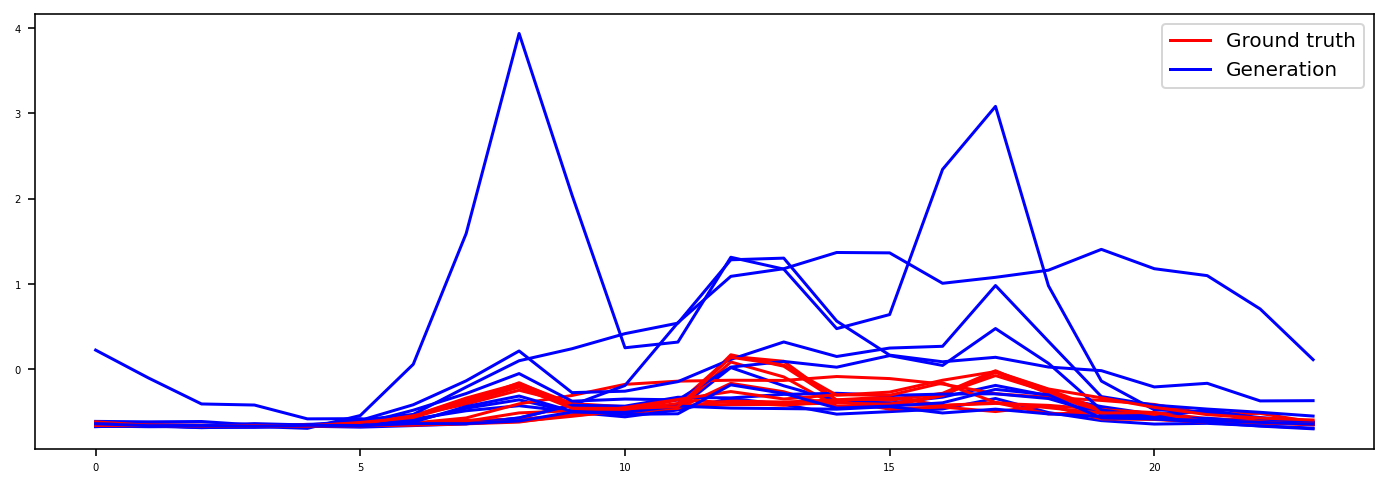

[-2.01e-02 -4.09e-02 -3.47e-02  6.97e-02 -2.03e-02 -3.29e-02 -5.23e-02
 -6.49e-02 -2.57e-02  1.20e-01 -1.50e-02 -5.48e-03  1.75e-01  4.22e-02
  5.65e-02 -4.42e-02  8.40e-02  3.59e-02  5.66e-02  7.52e-03 -2.30e-02
 -2.36e-02  6.63e-02 -1.22e-02 -6.22e-02  2.01e-02  1.23e-01  7.72e-02
 -9.72e-03 -3.06e-02  4.06e-03  3.39e-02  7.00e-02 -3.17e-02 -5.12e-02
  9.97e-02 -2.22e-02  3.99e-02 -5.30e-02 -5.05e-02 -3.68e-02 -6.34e-02
 -1.09e-02 -6.37e-02  6.37e-02  7.35e-02 -1.59e-02  6.43e-02  1.78e-01
 -2.19e-02 -4.60e-02 -2.52e-02  1.13e-04  9.64e-02  6.48e-02 -3.51e-02
  5.07e-02  1.78e-01  6.70e-03 -4.55e-02  1.19e-02  2.07e-02 -5.36e-02
 -5.01e-02 -5.65e-02 -5.70e-02 -8.64e-03 -5.01e-02  5.41e-02 -4.65e-02
 -6.71e-02 -4.56e-02 -3.83e-02 -3.73e-02 -5.12e-02  2.52e-02  4.27e-03
 -4.58e-02  5.09e-02  1.01e-01 -2.43e-02 -3.78e-02 -5.16e-02 -1.85e-02
 -5.66e-02 -2.88e-02  7.95e-02 -5.69e-02 -5.92e-02  1.25e-02  4.50e-02
  7.87e-02 -1.46e-02  2.11e-02  4.37e-02  9.43e-03  1.82e-01  4.24e-03
 -5.95

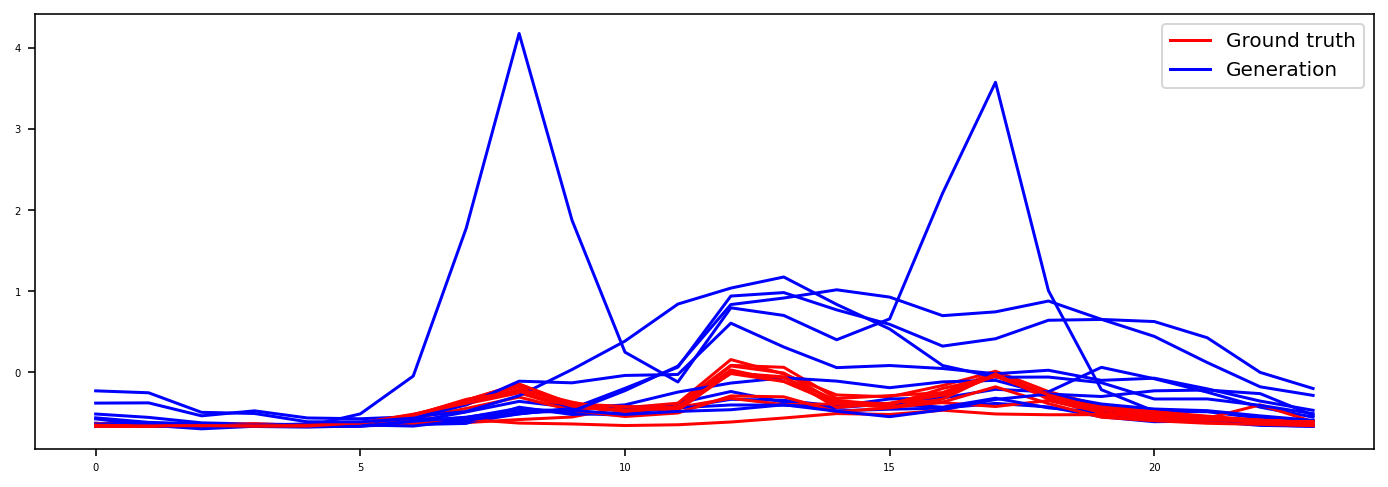

[-0.04  0.   -0.03 -0.05 -0.04 -0.04  0.03  0.03 -0.01 -0.03 -0.02 -0.03
 -0.01  0.   -0.04 -0.01  0.22 -0.02  0.12 -0.03 -0.04  0.    0.04 -0.04
  0.01  0.03  0.09  0.07  0.09 -0.05  0.02 -0.05 -0.03 -0.01 -0.02  0.12
  0.04  0.01 -0.02 -0.02 -0.04  0.07 -0.03 -0.04  0.01 -0.02 -0.01  0.01
 -0.03 -0.03 -0.03 -0.01 -0.03  0.08 -0.05 -0.03 -0.    0.04  0.04  0.05
  0.02 -0.03 -0.05 -0.02 -0.04 -0.01 -0.03 -0.05  0.04  0.02 -0.01 -0.04
 -0.02 -0.03 -0.05 -0.03  0.1  -0.02 -0.01  0.03 -0.02  0.   -0.03 -0.01
 -0.03  0.06  0.03 -0.03 -0.05  0.02 -0.03  0.    0.03 -0.04 -0.04 -0.03
 -0.02  0.01  0.13 -0.04]
reject


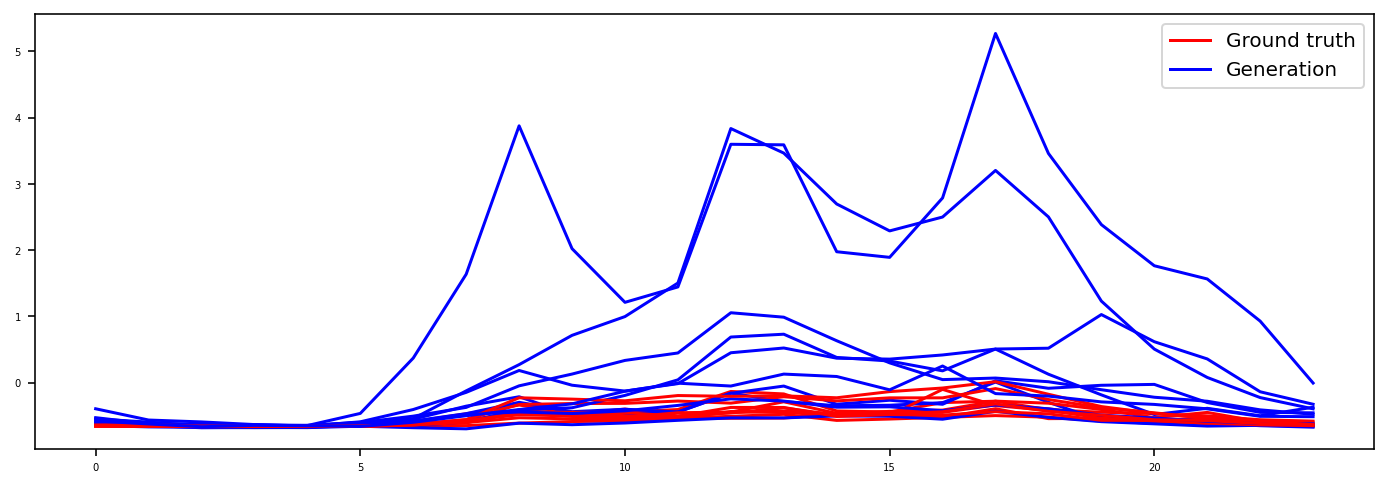

[ 4.44e-02 -4.74e-02 -2.59e-02 -2.11e-02 -5.36e-02 -3.82e-02 -2.98e-02
 -2.47e-02 -3.88e-02  1.45e-01 -7.09e-03 -5.95e-03 -3.95e-02 -4.16e-02
 -2.73e-02 -2.96e-02 -5.45e-02  8.74e-03  2.11e-02 -3.78e-02 -2.26e-02
 -3.19e-02  1.93e-02 -9.27e-03 -3.68e-02 -3.50e-02 -4.25e-02  2.62e-02
 -1.87e-02  7.64e-02 -3.95e-02  6.83e-02 -4.66e-02 -2.53e-02  2.51e-02
  4.24e-05 -4.90e-02 -4.16e-02  6.04e-02 -1.81e-02 -4.84e-02  7.55e-02
 -2.98e-02  1.81e-02 -5.51e-02 -3.99e-02 -2.75e-02 -3.32e-02 -4.58e-02
 -4.63e-02 -2.92e-02 -5.02e-02 -6.89e-03 -2.82e-02 -3.47e-02 -5.41e-02
  1.65e-02 -2.53e-02 -5.40e-02 -5.39e-02  2.29e-02 -8.05e-03 -3.14e-02
  3.55e-02 -2.02e-02 -5.89e-02  1.33e-01  9.41e-02 -5.30e-03 -4.98e-02
  6.39e-02 -5.48e-02 -2.83e-02 -3.94e-03 -3.06e-02  2.73e-02 -2.87e-02
  8.11e-02 -4.81e-02 -2.36e-03 -1.16e-02  1.23e-01  1.03e-01 -1.26e-02
 -3.76e-02 -2.52e-02 -2.55e-02 -4.62e-02  5.90e-02 -4.19e-02 -3.31e-02
 -3.56e-02 -3.57e-04  1.54e-03 -1.22e-02  4.39e-02 -4.24e-02 -4.45e-02
  1.88

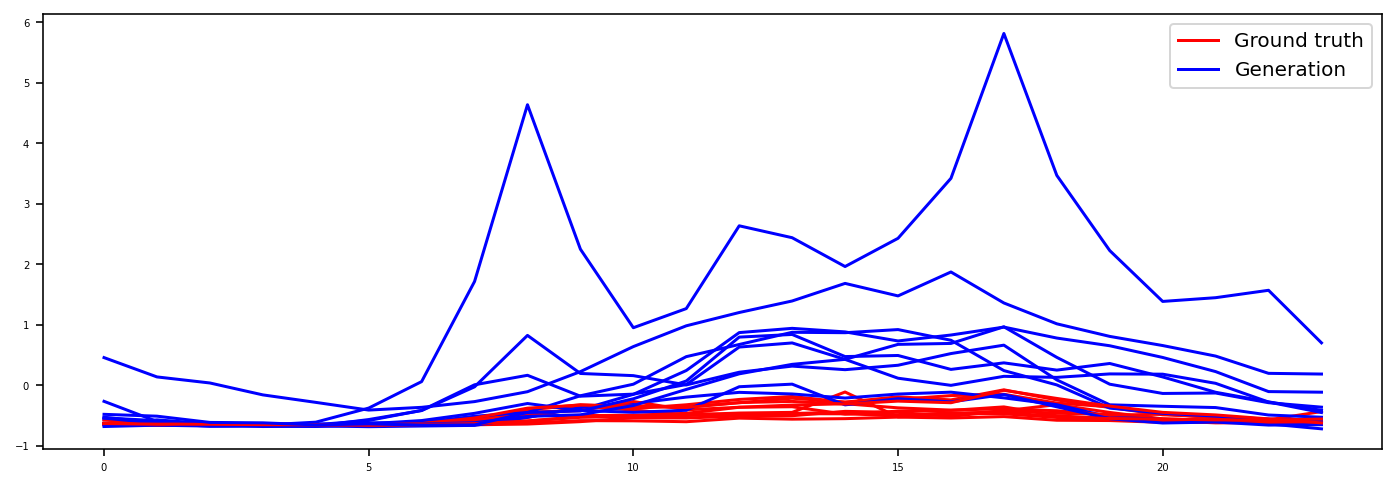

[ 0.01  0.1   0.04  0.04 -0.02 -0.01 -0.02  0.01  0.11  0.   -0.06  0.
 -0.03  0.02 -0.02  0.    0.06 -0.02  0.28 -0.01 -0.03  0.02  0.06 -0.03
  0.01  0.04 -0.06 -0.02 -0.01 -0.05 -0.04  0.04  0.01  0.03 -0.03 -0.07
  0.04  0.01 -0.05 -0.03 -0.03  0.29 -0.05 -0.   -0.01 -0.02 -0.04 -0.03
 -0.03  0.03  0.12 -0.07  0.15 -0.04 -0.01 -0.01 -0.02 -0.03 -0.03 -0.07
 -0.06 -0.03 -0.03 -0.04  0.03 -0.01 -0.07  0.04 -0.01  0.01  0.09  0.11
  0.14 -0.07  0.08  0.11 -0.03  0.11 -0.04  0.05  0.01  0.   -0.06  0.01
  0.   -0.07 -0.03 -0.03 -0.01  0.04  0.08  0.18  0.02  0.08  0.12 -0.01
 -0.07 -0.03  0.13  0.01]
reject


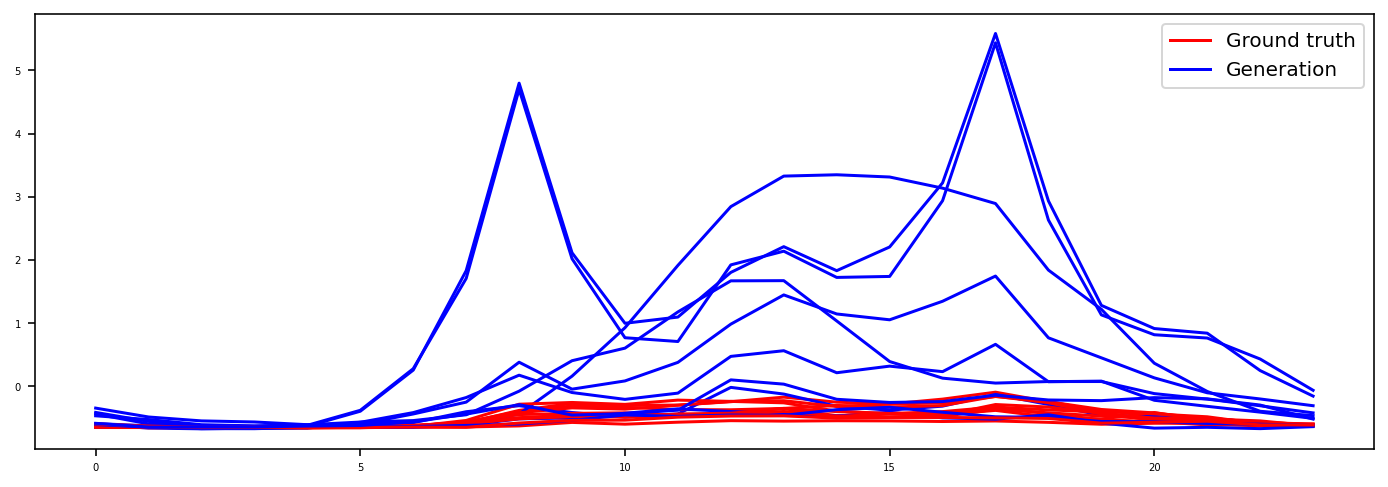

[-0.06  0.04 -0.01  0.   -0.03 -0.05 -0.05 -0.04 -0.06  0.01  0.03 -0.04
 -0.03 -0.04 -0.05  0.04  0.14  0.1  -0.04 -0.05 -0.04 -0.03 -0.05 -0.
  0.07  0.2   0.06  0.02 -0.03  0.05 -0.   -0.04 -0.05  0.01 -0.04 -0.
 -0.04  0.04 -0.06  0.02 -0.   -0.03  0.03 -0.06 -0.01  0.05  0.05 -0.03
 -0.02 -0.    0.03 -0.05 -0.02  0.03 -0.03 -0.05  0.03 -0.   -0.04  0.14
 -0.06  0.01 -0.03 -0.04 -0.04  0.05  0.02 -0.04 -0.03 -0.05  0.12 -0.04
  0.04  0.05 -0.05 -0.06 -0.06  0.01 -0.02  0.01 -0.04 -0.03  0.18  0.03
 -0.03 -0.02  0.01 -0.01 -0.02  0.19 -0.05 -0.04 -0.01 -0.01 -0.02 -0.06
 -0.05 -0.03 -0.02 -0.04]
reject


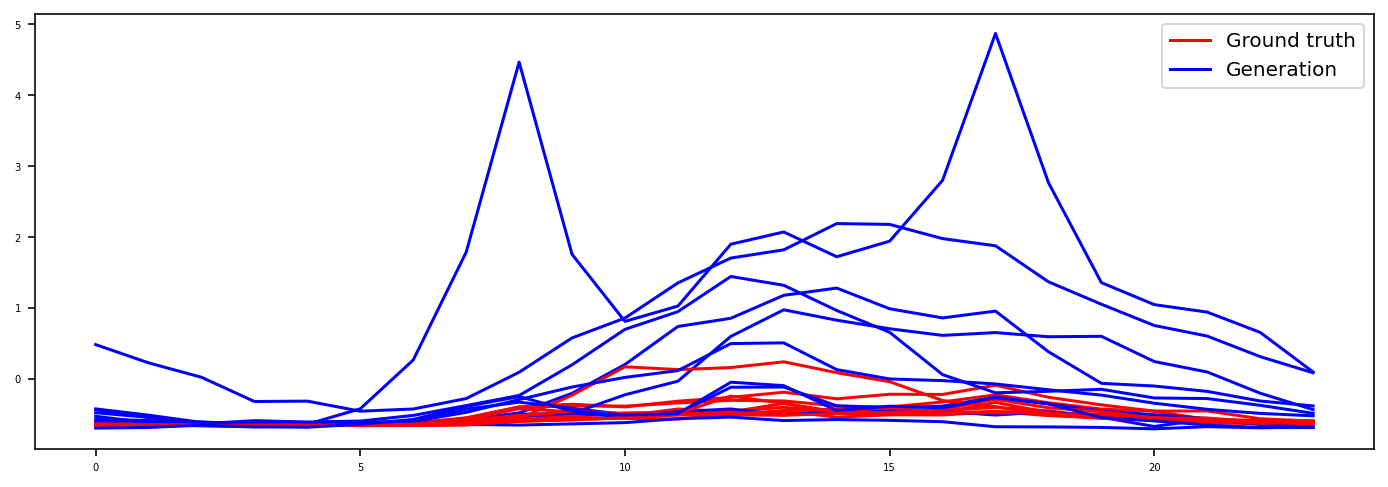

[-0.07  0.02  0.06 -0.03 -0.04  0.06 -0.06 -0.05 -0.01 -0.06 -0.01  0.01
  0.34  0.   -0.04 -0.06 -0.07 -0.03  0.17  0.09 -0.03 -0.04 -0.04 -0.01
  0.02 -0.03  0.   -0.02  0.18  0.01 -0.04  0.02  0.05  0.01  0.25 -0.05
 -0.04 -0.03  0.07  0.02  0.02 -0.    0.12 -0.01 -0.02 -0.05  0.08 -0.03
 -0.05 -0.04  0.01  0.28 -0.02 -0.02 -0.01 -0.04 -0.01 -0.02 -0.06 -0.06
  0.12 -0.05 -0.   -0.03 -0.01 -0.07 -0.03 -0.04  0.04 -0.    0.03 -0.01
  0.1   0.03 -0.03 -0.06 -0.02 -0.07 -0.02 -0.03 -0.03 -0.06 -0.01 -0.01
  0.   -0.02  0.07 -0.02 -0.04 -0.07  0.11  0.04 -0.01 -0.01 -0.07  0.02
 -0.03 -0.07  0.03  0.14]
reject


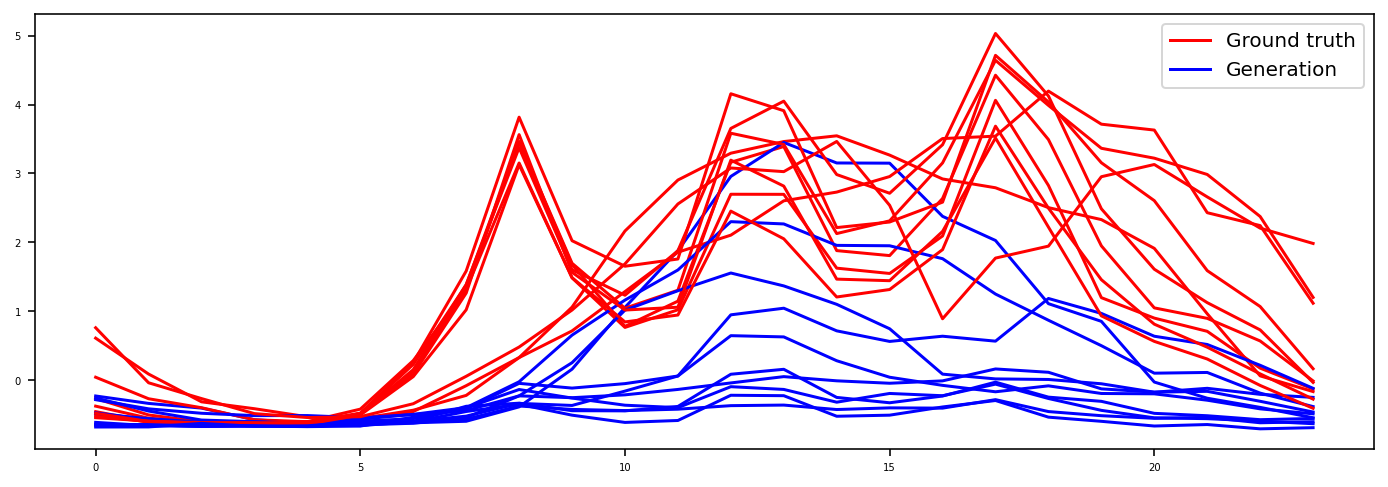

[ 0.   -0.01  0.08 -0.    0.05 -0.01 -0.03  0.08 -0.05 -0.02  0.4   0.01
 -0.06 -0.02 -0.06  0.08  0.14 -0.06 -0.06  0.06 -0.02 -0.05 -0.07 -0.07
  0.07 -0.04 -0.07  0.06 -0.06  0.01  0.03 -0.07 -0.05 -0.04 -0.06  0.01
 -0.04  0.03 -0.02 -0.07  0.01 -0.01 -0.04  0.14 -0.06  0.01  0.03 -0.05
  0.   -0.01 -0.06  0.06 -0.06 -0.03 -0.07 -0.03  0.01  0.06 -0.05 -0.04
 -0.   -0.02 -0.06 -0.01 -0.06 -0.06 -0.06  0.03  0.16 -0.    0.06  0.02
 -0.07 -0.03 -0.02 -0.01  0.06  0.01  0.03  0.06 -0.04  0.01 -0.03 -0.01
  0.02 -0.06 -0.04  0.22 -0.01  0.07 -0.02 -0.06  0.01 -0.04  0.2   0.03
 -0.05 -0.05 -0.03 -0.06]
reject


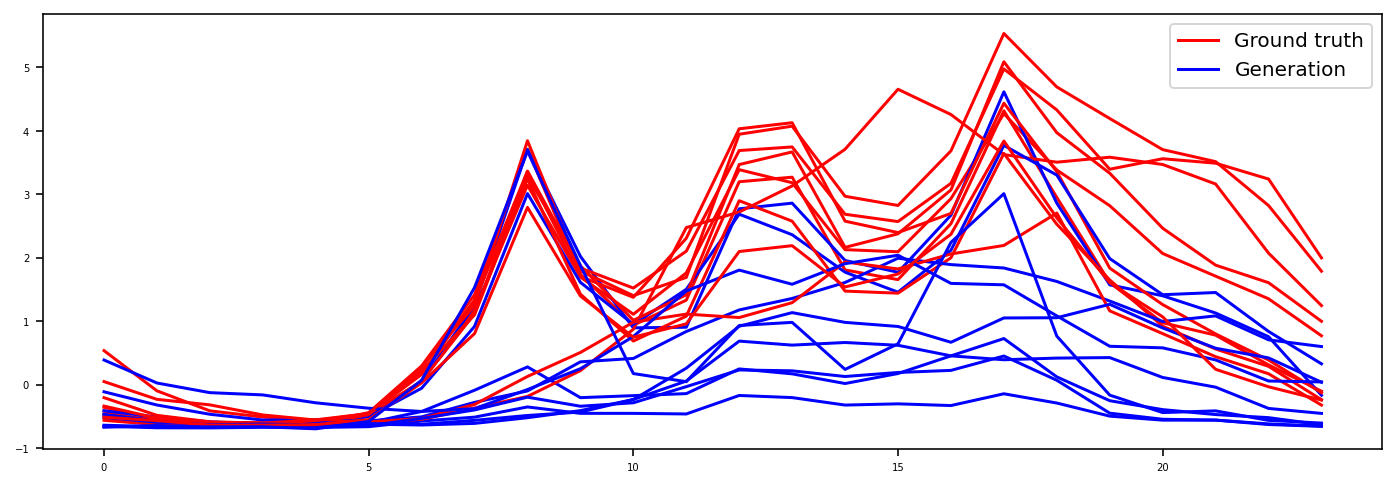

[ 0.    0.07  0.11 -0.01 -0.02  0.06 -0.06  0.1   0.36 -0.07 -0.07 -0.05
  0.15 -0.05 -0.05  0.05  0.37 -0.05  0.06 -0.06 -0.01 -0.02 -0.03  0.02
  0.1  -0.01  0.01 -0.07 -0.05  0.3  -0.03  0.16 -0.06 -0.06 -0.07 -0.02
 -0.01 -0.05  0.21 -0.06  0.14 -0.03 -0.06 -0.04 -0.06 -0.06 -0.07 -0.01
 -0.06 -0.04 -0.05 -0.06 -0.04 -0.02  0.22 -0.04 -0.02 -0.01  0.06  0.05
  0.11  0.04  0.02  0.01 -0.07 -0.03 -0.06 -0.04 -0.05 -0.02 -0.06 -0.03
 -0.02 -0.03  0.13 -0.06 -0.06  0.14 -0.06  0.02 -0.02 -0.05 -0.04 -0.06
  0.09  0.2  -0.04 -0.02 -0.03  0.06 -0.05 -0.04  0.03 -0.04 -0.06 -0.03
 -0.04 -0.02  0.04  0.02]
reject


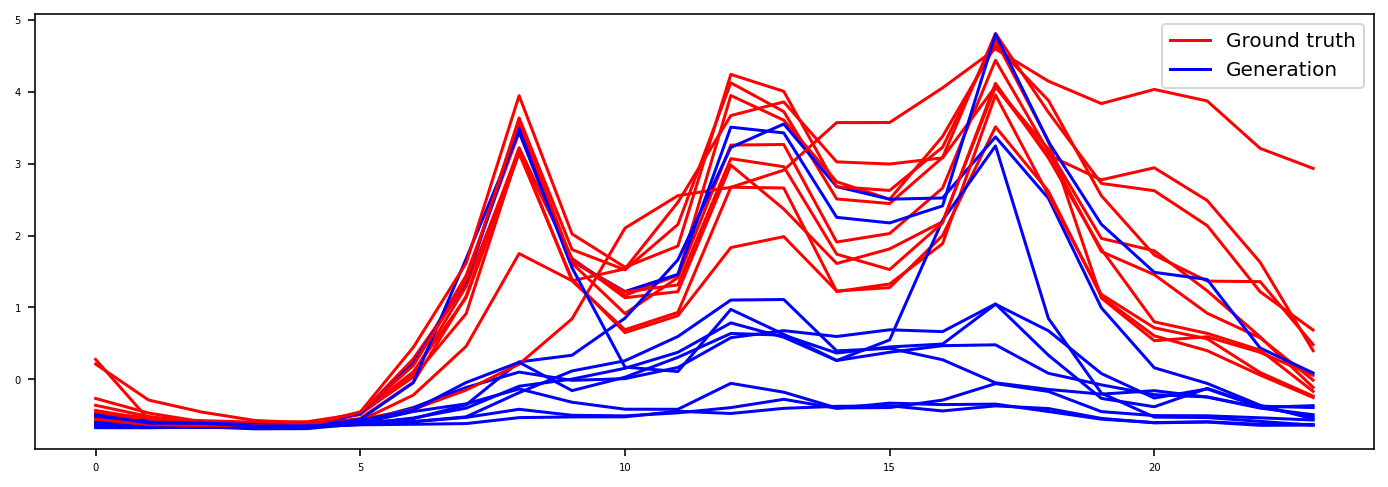

[ 2.61e-02 -5.96e-02 -2.91e-02  8.67e-02 -3.75e-02 -2.53e-02  1.28e-01
 -6.15e-02  1.73e-01 -1.83e-02 -4.95e-02 -3.12e-02 -3.80e-02 -3.08e-02
 -3.88e-02  8.59e-02 -4.98e-02 -1.04e-02 -5.63e-02 -3.05e-02 -4.37e-02
 -5.05e-02 -3.35e-02 -2.58e-02 -1.27e-03 -6.01e-02 -6.64e-02 -2.33e-02
 -1.40e-02  1.62e-01 -2.85e-02 -3.99e-02  7.47e-02 -1.04e-03 -8.00e-03
  9.52e-03 -1.98e-02 -5.73e-02 -6.83e-02 -3.90e-02  5.45e-02 -1.26e-02
 -3.58e-02  1.06e-02  1.76e-01  8.21e-02 -3.85e-02  7.89e-02  3.34e-02
 -4.24e-02 -6.50e-02 -5.48e-02 -6.55e-02  1.05e-02  1.23e-02  1.44e-02
  7.31e-02 -4.38e-02 -4.01e-02 -6.27e-02 -3.78e-02 -5.47e-02 -1.77e-02
  2.17e-01 -6.16e-02 -6.60e-02 -2.48e-02  9.02e-02 -1.35e-02  2.70e-02
 -1.09e-02 -6.59e-02 -6.57e-02 -5.25e-03 -1.03e-02  2.67e-03 -2.97e-02
 -3.88e-02 -6.11e-02  1.10e-01 -1.10e-02 -6.61e-02  3.99e-05 -6.20e-02
 -5.33e-02 -1.08e-02 -5.93e-03  7.37e-02  7.53e-02  5.22e-03 -5.94e-03
  4.76e-02 -6.48e-02 -4.94e-02 -1.69e-02 -5.57e-02 -2.37e-02 -4.43e-02
 -3.58

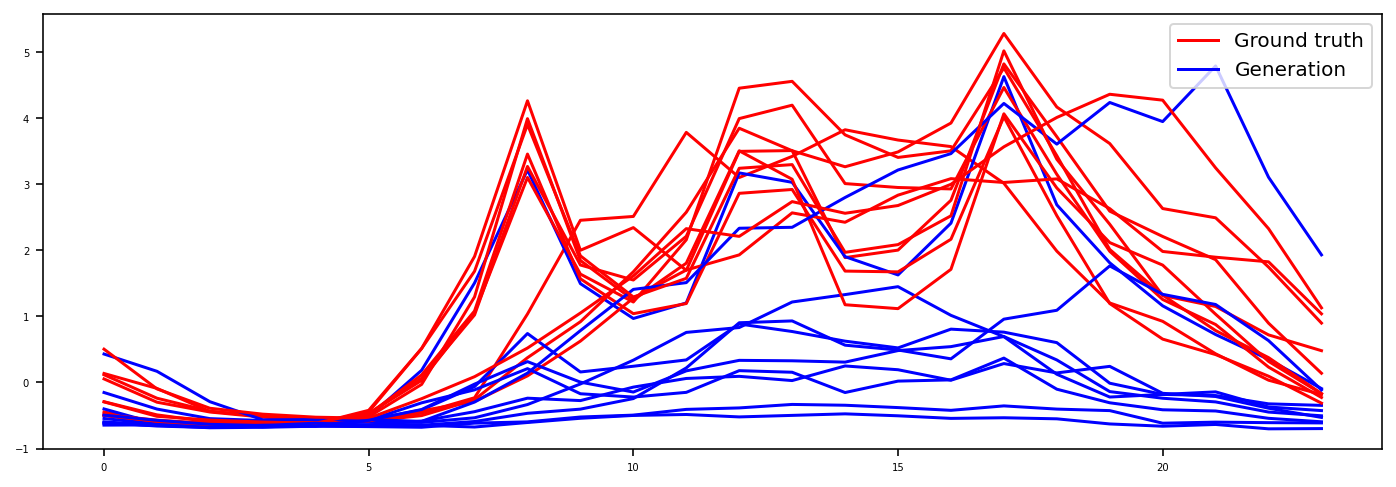

[-0.05 -0.04 -0.02  0.01  0.14  0.1  -0.03 -0.01 -0.03 -0.01  0.09 -0.03
 -0.02 -0.03  0.03 -0.04 -0.02  0.   -0.04  0.24 -0.03 -0.02  0.02  0.01
 -0.03 -0.02 -0.02  0.02  0.11 -0.03 -0.04 -0.02 -0.04 -0.05 -0.03 -0.05
 -0.02  0.13 -0.01 -0.01 -0.   -0.05 -0.02 -0.    0.1  -0.04  0.04  0.04
 -0.02 -0.03 -0.01 -0.05 -0.03 -0.01  0.02 -0.04 -0.02 -0.03 -0.01  0.07
 -0.05 -0.03  0.04 -0.02 -0.05 -0.05 -0.05 -0.06 -0.01  0.02 -0.02 -0.05
 -0.01 -0.01 -0.03 -0.02 -0.03  0.02 -0.04 -0.05 -0.03  0.03 -0.04 -0.06
  0.02  0.02 -0.04  0.01 -0.05 -0.02 -0.06  0.09  0.18 -0.04  0.03  0.03
 -0.04 -0.01 -0.01 -0.07]
reject


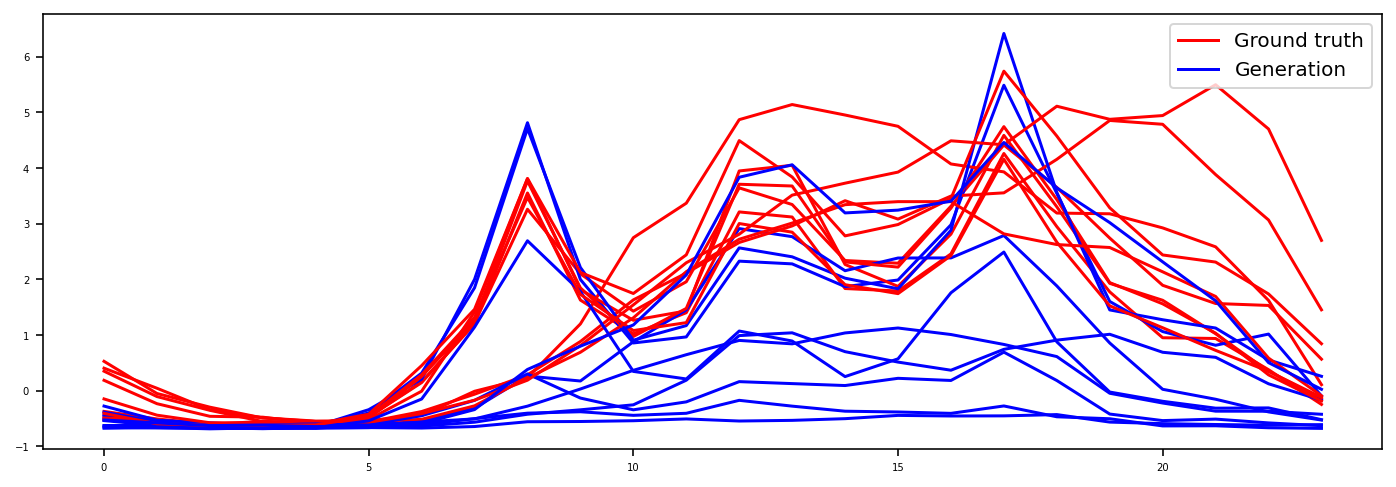

Power = 91.30%


In [17]:
X = torch2np(y_0).squeeze(-1) # ground truth -> reduce dimension [B, N, D] -> [B, N]
Y = torch2np(y_t).squeeze(-1) # prediction -> redice dimension [B, N, D] -> [B, N]

assert len(X.shape) == 2
assert len(Y.shape) == 2

n_tests = X.shape[0] // 10
n_perms = 100
gamma = -1

power = power_test(X_samples=X, Y_samples=Y, gamma=gamma, n_tests=n_tests, n_perms=n_perms)
print(f'Power = {power * 100:.2f}%')